In [1]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel

# import adapters
# from adapters import AutoAdapterModel
# import gc

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# from sklearn.decomposition import TruncatedSVD
# from sklearn.preprocessing import normalize

# from openTSNE import TSNE, affinity

import matplotlib.pyplot as plt
import matplotlib as mpl


import pickle
import time
import memory_profiler
from tqdm.notebook import tqdm

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

In [2]:
# old one '1.8.1+cu111'
torch.__version__

'2.1.1+cu121'

In [3]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.model_stuff import train_loop 
from text_embeddings_src.data_stuff import (
    MultOverlappingSentencesPairDataset,
)
# from text_embeddings_src.metrics import knn_accuracy, logistic_accuracy
# from text_embeddings_src.dim_red import run_tsne_simple
# from text_embeddings_src.plotting import plot_tsne_colors

In [4]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [5]:
variables_path = Path("../../results/variables")
# variables_pubmed_path = Path("../../pubmed-landscape/results/variables")
figures_path = Path("../../results/figures/updated_dataset")
data_path = Path("../../data")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")

In [6]:
# MANUAL FIX TO PATH ISSUE FROM VSCODE
import text_embeddings_src

nb_path = Path(text_embeddings_src.__path__[0]).parents[0] / Path(
    "scripts/updated_dataset"
)
assert nb_path.exists(), "The path does not exist"

variables_path = (nb_path / variables_path).resolve(strict=True)
figures_path = (nb_path / figures_path).resolve(strict=True)
data_path = (nb_path / data_path).resolve(strict=True)

In [7]:
plt.style.use((nb_path / Path("../matplotlib_style.txt")).resolve(strict=True))

In [8]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers -p openTSNE
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2024-07-15 13:28:28CEST

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

openTSNE: 1.0.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-1160.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

text_embeddings_src: 0.0.0
distro             : 1.8.0
numpy              : 1.26.2
matplotlib         : 3.8.2
sklearn            : 1.3.2
black              : 23.11.0
scipy              : 1.11.4
memory_profiler    : 0.61.0
jupyter_black      : 0.3.4
pandas             : 2.1.3
torch              : 2.1.1

Watermark: 2.4.3

Ubuntu 22.04.3 LTS


# Import ICLR dataset

In [9]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    # index=False,
    engine="pyarrow",
    # compression="gzip",
)

CPU times: user 290 ms, sys: 89.2 ms, total: 379 ms
Wall time: 280 ms


In [10]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [11]:
iclr2024

,index,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,0,2017,S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,We introduce a design strategy for neural netw...,"Gustav Larsson, Michael Maire, Gregory Shakhna...",Accept (Poster),"[5, 7, 6, 6]",[],male,male,-28.117955,-20.418127
1,1,2017,H1W1UN9gg,Deep Information Propagation,We study the behavior of untrained neural netw...,"Samuel S. Schoenholz, Justin Gilmer, Surya Gan...",Accept (Poster),"[8, 9, 8]","[theory, deep learning]",male,None,-32.466820,-10.791123
2,2,2017,r1GKzP5xx,Recurrent Normalization Propagation,We propose a LSTM parametrization that preser...,"César Laurent, Nicolas Ballas, Pascal Vincent",Invite to Workshop Track,"[4, 6, 6]","[deep learning, optimization]",None,male,3.504240,19.946053
3,3,2017,S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,Recurrent neural nets are widely used for pred...,"K, a, m, i, l, , R, o, c, k, i",Reject,"[3, 4, 3]","[unsupervised learning, applications, deep lea...",None,None,4.553473,16.037763
4,4,2017,SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,We propose a new formulation for pruning convo...,"Pavlo Molchanov, Stephen Tyree, Tero Karras, T...",Accept (Poster),"[6, 7, 9]","[deep learning, transfer learning]",None,male,-25.827705,-37.891772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24342,7299,2024,1bbPQShCT2,I-PHYRE: Interactive Physical Reasoning,Current evaluation protocols predominantly ass...,,,[],"[intuitive physics, physical reasoning]",None,None,43.137120,44.316133
24343,7300,2024,Ny150AblPu,EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...,In the battle against widespread online misinf...,,,[],"[mis-contextualization, media forensic]",None,None,59.742172,-22.673627
24344,7301,2024,ZGBOfAQrMl,Video Super-Resolution Transformer with Masked...,"Recently, Vision Transformer has achieved grea...",,,[],"[video super-resolution, adaptive, memory and ...",None,None,57.933273,-3.932825
24345,7302,2024,J2kRjUAOLh,Contrastive Predict-and-Search for Mixed Integ...,Mixed integer linear programs (MILP) are flex...,,,[],[mixed integer programs; contrastive learning],None,None,-11.437999,21.289523


In [12]:
labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

In [13]:
# sanity check
print(len(np.unique(labels_iclr)))
labels_iclr

46


array(['unlabeled', 'unlabeled', 'optimization', ..., 'unlabeled',
       'unlabeled', 'federated learning'], dtype='<U34')

# Functions

In [17]:
def fix_all_seeds(seed=42):
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  ## this one is new
    ## Set the seed for generating random numbers on all GPUs.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True) ## this one I don't use but don't remember why

    # Set the random seed for NumPy
    np.random.seed(seed)

    # Set the random seed
    random.seed(seed)

## Function train model without evaluation

In [18]:
import torch
from tqdm.notebook import tqdm
from transformers.optimization import get_linear_schedule_with_warmup
from text_embeddings_src.model_stuff import mean_pool


def train_loop_without_eval(
    model,
    loader,
    device,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
):
    assert optimized_rep in [
        "av",
        "cls",
        "sep",
        "7th",
    ], "Not valid `optimized_rep`. Choose from ['av', 'cls', 'sep', '7th']."

    model.to(device)

    # define layers to be used in multiple-negatives-ranking
    cos_sim = torch.nn.CosineSimilarity()
    loss_func = torch.nn.CrossEntropyLoss()
    scale = 20.0  # we multiply similarity score by this scale value, it is the inverse of the temperature
    # move layers to device
    cos_sim.to(device)
    loss_func.to(device)

    # initialize Adam optimizer
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # setup warmup for first ~10% of steps
    total_steps = len(loader) * n_epochs
    warmup_steps = int(0.1 * len(loader))
    scheduler = get_linear_schedule_with_warmup(
        optim,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    losses = np.empty((n_epochs, len(loader)))
    accuracies = []
    for epoch in range(n_epochs):
        model.train()  # make sure model is in training mode
        # initialize the dataloader loop with tqdm (tqdm == progress bar)
        loop = tqdm(loader, leave=True)
        for i_batch, batch in enumerate(loop):
            # zero all gradients on each new step
            optim.zero_grad()
            # prepare batches and move all to the active device
            anchor_ids = batch[0][0].to(
                device
            )  # this are all anchor abstracts from the batch,len(anchor_ids)= len(batch)
            anchor_mask = batch[0][1].to(device)
            pos_ids = batch[1][0].to(
                device
            )  # this each positive pair from each anchor, all in one array, also len(batch)
            pos_mask = batch[1][1].to(device)
            # extract token embeddings from BERT
            a = model(anchor_ids, attention_mask=anchor_mask)[
                0
            ]  # all token embeddings
            p = model(pos_ids, attention_mask=pos_mask)[0]

            # get the mean pooled vectors  -- put all of these ifs into a pool function (wraper) to which I pass, a, p the masks and the optimized rep
            if optimized_rep == "av":
                a = mean_pool(a, anchor_mask)
                p = mean_pool(p, pos_mask)

            elif optimized_rep == "cls":
                a = cls_pool(a, anchor_mask)
                p = cls_pool(p, pos_mask)

            elif optimized_rep == "sep":
                a = sep_pool(a, anchor_mask)
                p = sep_pool(p, pos_mask)

            elif optimized_rep == "7th":
                a = seventh_pool(a, anchor_mask)
                p = seventh_pool(p, pos_mask)

            # calculate the cosine similarities
            scores = torch.stack(
                [cos_sim(a_i.reshape(1, a_i.shape[0]), p) for a_i in a]
            )
            # get label(s) - we could define this before if confident
            # of consistent batch sizes
            labels = torch.tensor(
                range(len(scores)), dtype=torch.long, device=scores.device
            )  # I think that the labels are just the label of which pair it is. 0 for the first pair, 1 for the second...
            # my guess is that they are used in the loss to know which of the cosine similarities should be high
            # and which low

            # and now calculate the loss
            loss = loss_func(scores * scale, labels)
            losses[epoch, i_batch] = loss.item()

            # using loss, calculate gradients and then optimize
            loss.backward()
            optim.step()
            # update learning rate scheduler
            scheduler.step()
            # update the TDQM progress bar
            loop.set_description(f"Epoch {epoch}")
            loop.set_postfix(loss=loss.item())

        return model, losses

## function get embeddings of all tokens

In [19]:
import datasets
from tqdm.notebook import tqdm


def generate_embeddings_all_tokens(
    abstracts,
    tokenizer,
    model,
    device,
    batch_size=256,
    show_progress=False,
):
    """Generate embeddings using BERT-based model.

    Parameters
    ----------
    abstracts : list, this has to be a list not sure if array works but pandas do not work
        Abstract texts.
    tokenizer : transformers.models.bert.tokenization_bert_fast.BertTokenizerFast
        Tokenizer.
    model : transformers.models.bert.modeling_bert.BertModel
        BERT-based model.
    device : str, {"cuda", "cpu"}
        "cuda" if torch.cuda.is_available() else "cpu".

    Returns
    -------
    embedding_cls : ndarray
        [CLS] tokens of the abstracts.
    embedding_sep : ndarray
        [SEP] tokens of the abstracts.
    embedding_av : ndarray
        Average of tokens of the abstracts.
    """
    # preprocess the input
    inputs = tokenizer(
        abstracts,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512,
    ).to(device)

    dataset = datasets.Dataset.from_dict(inputs)
    dataset.set_format(type="torch", output_all_columns=True)
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, num_workers=10
    )

    embedding = []

    with torch.no_grad():
        model.eval()

        for batch in tqdm(loader) if show_progress == True else loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(**batch)
            token_embeds = out[0]  # get the last hidden state
            embedding.append(token_embeds.detach().cpu().numpy())

    embedding = np.vstack(embedding)
    return embedding

In [20]:
import datasets
from tqdm.notebook import tqdm


def generate_embeddings_all_tokens_across_layers(
    abstracts,
    tokenizer,
    model,
    device,
    layers,
    batch_size=256,
    show_progress=False,
):
    """Generate embeddings using BERT-based model.

    Parameters
    ----------
    abstracts : list, this has to be a list not sure if array works but pandas do not work
        Abstract texts.
    tokenizer : transformers.models.bert.tokenization_bert_fast.BertTokenizerFast
        Tokenizer.
    model : transformers.models.bert.modeling_bert.BertModel
        BERT-based model.
    device : str, {"cuda", "cpu"}
        "cuda" if torch.cuda.is_available() else "cpu".

    Returns
    -------
    embedding_cls : ndarray
        [CLS] tokens of the abstracts.
    embedding_sep : ndarray
        [SEP] tokens of the abstracts.
    embedding_av : ndarray
        Average of tokens of the abstracts.
    """
    # preprocess the input
    inputs = tokenizer(
        abstracts,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512,
    ).to(device)

    dataset = datasets.Dataset.from_dict(inputs)
    dataset.set_format(type="torch", output_all_columns=True)
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, num_workers=10
    )

    embeddings_layers = dict()

    with torch.no_grad():
        model.eval()

        for i, batch in (
            enumerate(tqdm(loader))
            if show_progress == True
            else enumerate(loader)
        ):
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(**batch, output_hidden_states=True)

            for layer_number in layers:
                if i == 0:
                    embeddings_layers[layer_number] = [
                        out.hidden_states[layer_number].detach().cpu().numpy()
                    ]
                else:
                    embeddings_layers[layer_number].append(
                        out.hidden_states[layer_number].detach().cpu().numpy()
                    )

    # convert to array
    for layer_number in layers:
        embeddings_layers[layer_number] = np.vstack(
            embeddings_layers[layer_number]
        )

    return embeddings_layers

# Dummy corpus

In [7]:
dummy_corpus = [
"The sun is shining brightly in the clear blue sky.",
"She made a delicious chocolate cake for dessert.",
"They are planning a trip to Paris next summer.",
"The soccer team won the championship game yesterday.",
"He bought a new smartphone with a high-resolution camera.",
]

In [8]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

## Untrained model

In [18]:
%%time
# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model_untrained = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

model_untrained.to(device)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
CPU times: user 1.81 s, sys: 1.23 s, total: 3.04 s
Wall time: 1.24 s


MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [29]:
# preprocess the input
inputs = tokenizer(
    dummy_corpus,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)


out = model_untrained(**inputs)
token_embeds = out[0].detach().cpu().numpy()  # get the last hidden state


In [30]:
token_embeds.shape

(5, 14, 768)

In [189]:
# does the same as code above
untrained_token_embedds = generate_embeddings_all_tokens(
    dummy_corpus, tokenizer, model_untrained, device
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [194]:
untrained_token_norms = np.linalg.norm(untrained_token_embedds, axis=2)
untrained_token_norms.shape

(5, 14)

### Get tokens names

In [38]:
tokens = tokenizer.tokenize(dummy_corpus[0])
tokens

['the',
 'sun',
 'is',
 'shining',
 'brightly',
 'in',
 'the',
 'clear',
 'blue',
 'sky',
 '.']

In [49]:
inputs["input_ids"].cpu()

tensor([[    0,  2000,  3107,  2007,  9720, 14228,  2003,  2000,  3158,  2634,
          3716,  1016,     2,     1],
        [    0,  2020,  2085,  1041, 12094,  7971,  9854,  2009, 18068,  1016,
             2,     1,     1,     1],
        [    0,  2031,  2028,  4045,  1041,  4444,  2004,  3004,  2283,  2625,
          1016,     2,     1,     1],
        [    0,  2000,  4719,  2140,  2184,  2000,  2532,  2212,  7487,  1016,
             2,     1,     1,     1],
        [    0,  2006,  4153,  1041,  2051, 26385,  2011,  1041,  2156,  1015,
          5817,  4954,  1016,     2]])

In [61]:
tokenizer.batch_decode(inputs["input_ids"])

['<s> the sun is shining brightly in the clear blue sky. </s> <pad>',
 '<s> she made a delicious chocolate cake for dessert. </s> <pad> <pad> <pad>',
 '<s> they are planning a trip to paris next summer. </s> <pad> <pad>',
 '<s> the soccer team won the championship game yesterday. </s> <pad> <pad> <pad>',
 '<s> he bought a new smartphone with a high - resolution camera. </s>']

In [62]:
tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

['<s>',
 'the',
 'sun',
 'is',
 'shining',
 'brightly',
 'in',
 'the',
 'clear',
 'blue',
 'sky',
 '.',
 '</s>',
 '<pad>']

In [53]:
tokenizer.get_added_vocab()

{'<s>': 0, '<pad>': 1, '</s>': 2, '<unk>': 3, '[UNK]': 104, '<mask>': 30526}

In [59]:
tokenizer

MPNetTokenizerFast(name_or_path='microsoft/mpnet-base', vocab_size=30527, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	104: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	30526: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, speci

### Do plot of token norms

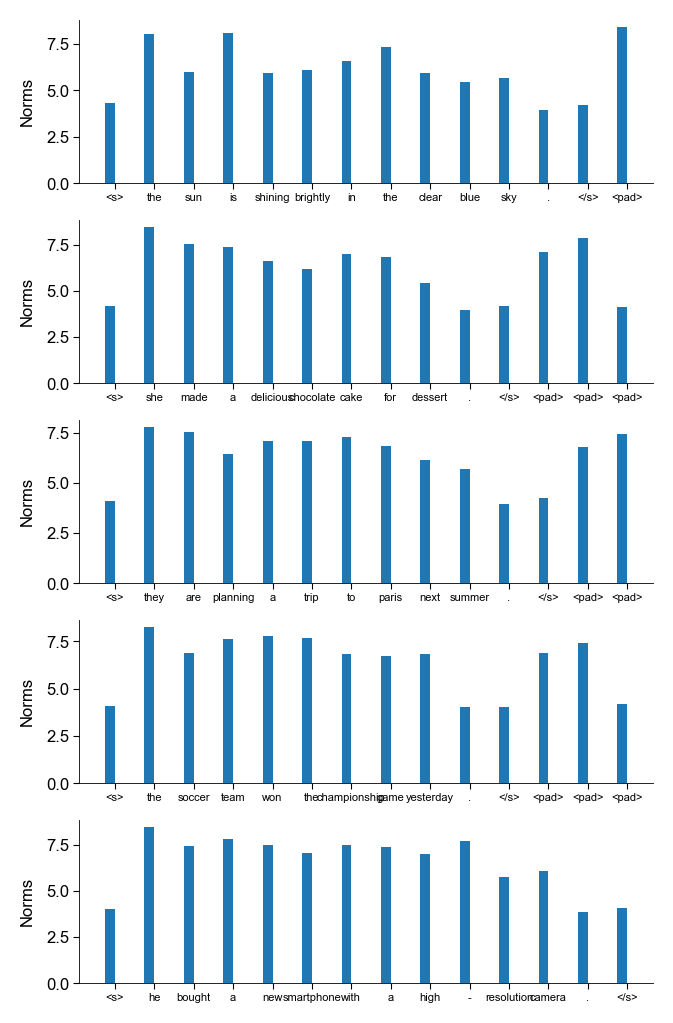

In [94]:
%matplotlib inline

fig, axs = plt.subplots(5,1, figsize=(3.25, 5), dpi=200, layout="constrained")
# fig, ax = plt.subplots(figsize=(3.25, 1), dpi=200)


for i, ax in enumerate(axs):
    width = 0.25  
    offset = width/2
    ax.bar(np.arange(token_norms.shape[1])-offset, token_norms[i], width=width)
    # ax.bar(np.arange(token_norms.shape[1])+offset, token_norms[i], width=width)
    ax.set_xticks(np.arange(token_norms.shape[1]))
    ax.set_xticklabels(tokenizer.convert_ids_to_tokens(inputs["input_ids"][i]), fontsize=4)#, rotation="vertical")
    ax.set_ylabel("Norms")



## Trained model
Train model on ICLR data for one epoch

In [103]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [110]:
%%time
# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model_untrained = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("Training loader length: ", len(training_loader))

model_trained, losses = train_loop_without_eval(
    model_untrained,
    training_loader,
    device,
    optimized_rep="av",
    n_epochs=1,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Training loader length:  368


  0%|          | 0/368 [00:00<?, ?it/s]

CPU times: user 6min 22s, sys: 4min 21s, total: 10min 44s
Wall time: 5min 17s


In [195]:
trained_token_embeds = generate_embeddings_all_tokens(
    dummy_corpus, tokenizer, model_trained, device
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [134]:
trained_token_embeds.shape

(5, 14, 768)

In [135]:
trained_token_norms = np.linalg.norm(trained_token_embeds, axis=2)

In [136]:
print(trained_token_embeds.shape)
print(trained_token_norms.shape)

(5, 14, 768)
(5, 14)


## Plot

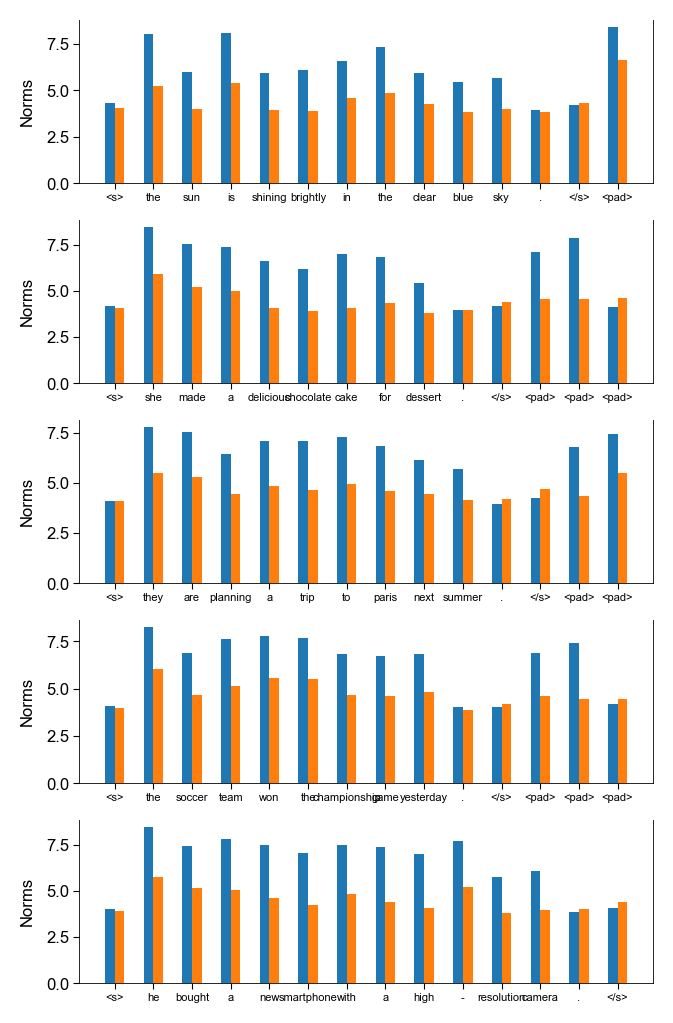

In [196]:
%matplotlib inline

fig, axs = plt.subplots(5,1, figsize=(3.25, 5), dpi=200, layout="constrained")
# fig, ax = plt.subplots(figsize=(3.25, 1), dpi=200)


for i, ax in enumerate(axs):
    width = 0.25  
    offset = width/2
    ax.bar(np.arange(token_norms.shape[1])-offset, untrained_token_norms[i], width=width)
    ax.bar(np.arange(token_norms.shape[1])+offset, trained_token_norms[i], width=width)
    ax.set_xticks(np.arange(token_norms.shape[1]))
    ax.set_xticklabels(tokenizer.convert_ids_to_tokens(inputs["input_ids"][i]), fontsize=4)#, rotation="vertical")
    ax.set_ylabel("Norms")



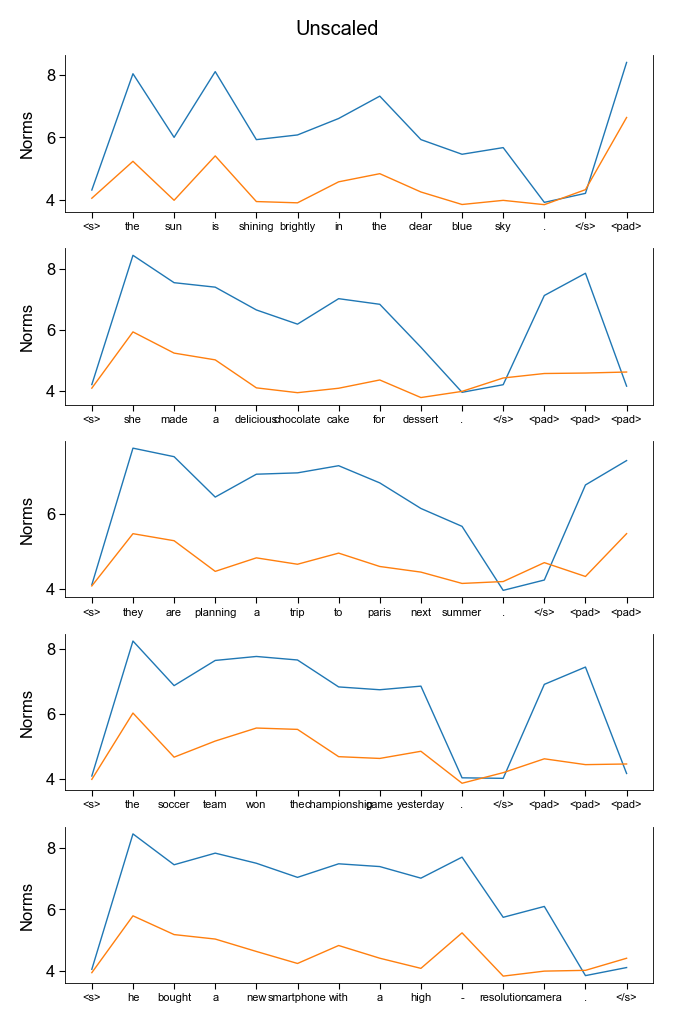

In [224]:
%matplotlib inline

fig, axs = plt.subplots(5,1, figsize=(3.25, 5), dpi=200, layout="constrained")

# create xticks
inputs = tokenizer(
    dummy_corpus,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)

fig.suptitle("Unscaled")
for i, ax in enumerate(axs):
    ax.plot(np.arange(token_norms.shape[1]), untrained_token_norms[i])
    ax.plot(np.arange(token_norms.shape[1]), trained_token_norms[i])
    ax.set_xticks(np.arange(token_norms.shape[1]))
    ax.set_xticklabels(tokenizer.convert_ids_to_tokens(inputs["input_ids"][i]), fontsize=4)#, rotation="vertical")
    ax.set_ylabel("Norms")



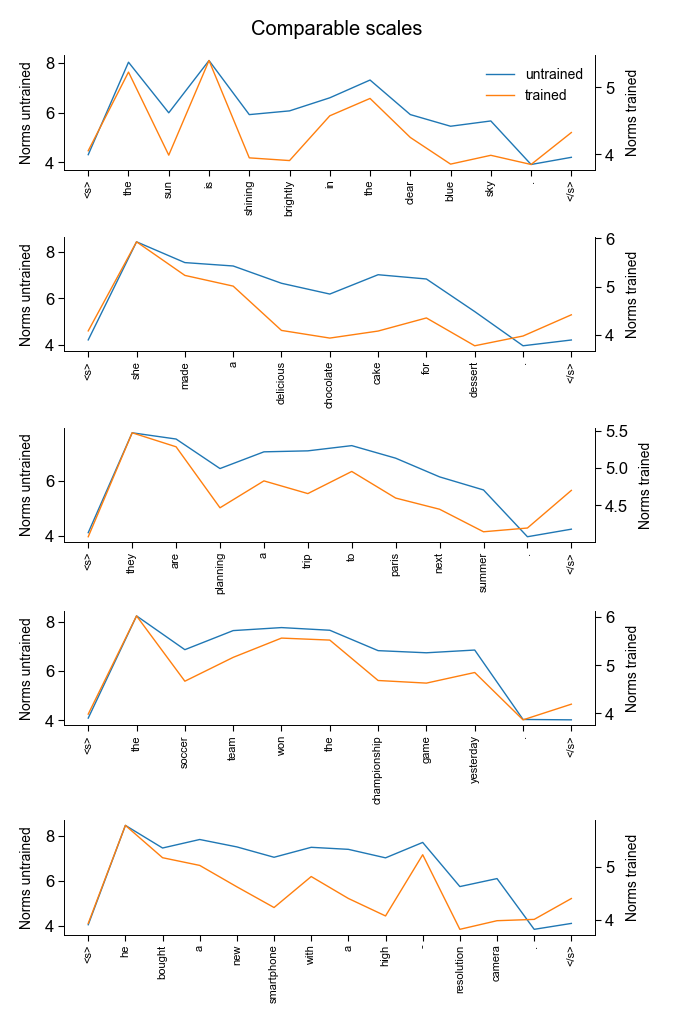

In [223]:
%matplotlib inline
# WITHOUT PAD TOKS

fig, axs = plt.subplots(5,1, figsize=(3.25, 5), dpi=200, layout="constrained")

# create xticks
inputs = tokenizer(
    dummy_corpus,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)


untrained = untrained_token_norms
trained = trained_token_norms

fig.suptitle("Comparable scales")
for i, ax in enumerate(axs):
    ax2 = ax.twinx()
    
    xticks_labels = np.array(
        tokenizer.convert_ids_to_tokens(inputs["input_ids"][i])
    )
    x = np.arange(untrained.shape[1])[: np.sum(xticks_labels != "<pad>")]
    ax.plot(x, untrained[i][: np.sum(xticks_labels != "<pad>")], label= "untrained")
    ax2.plot(x, trained[i][: np.sum(xticks_labels != "<pad>")], c="tab:orange", label= "trained")
    ax.set_xticks(x)
    ax.set_xticklabels(xticks_labels[: np.sum(xticks_labels != "<pad>")], fontsize=4, rotation="vertical")
    ax.set_ylabel("Norms untrained", fontsize=5)
    ax2.set_ylabel("Norms trained", fontsize=5)
    if i == 0:
        ax.plot([],[],c="tab:orange", label= "trained")
        ax.legend()



# Dummy corpus 2

In [29]:
for elem in iclr2024.abstract[:5]:
    print(elem)
    print("------")

We introduce a design strategy for neural network macro-architecture based on self-similarity.  Repeated application of a simple expansion rule generates deep networks whose structural layouts are precisely truncated fractals.  These networks contain interacting subpaths of different lengths, but do not include any pass-through or residual connections; every internal signal is transformed by a filter and nonlinearity before being seen by subsequent layers.  In experiments, fractal networks match the excellent performance of standard residual networks on both CIFAR and ImageNet classification tasks, thereby demonstrating that residual representations may not be fundamental to the success of extremely deep convolutional neural networks.  Rather, the key may be the ability to transition, during training, from effectively shallow to deep.  We note similarities with student-teacher behavior and develop drop-path, a natural extension of dropout, to regularize co-adaptation of subpaths in fra

In [30]:
dummy_sci_corpus = [
    "We introduce a design strategy for neural network macro-architecture based on self-similarity.",
    "We study the behavior of untrained neural networks whose weights and biases are randomly distributed using mean field theory.",
    "We propose a LSTM parametrization  that preserves the means and variances of the hidden states and memory cells across time.",
    "Recurrent neural nets are widely used for predicting temporal data.",
    "We propose a new formulation for pruning convolutional kernels in neural networks to enable efficient inference.",
]

In [31]:
print(dummy_sci_corpus)

['We introduce a design strategy for neural network macro-architecture based on self-similarity.', 'We study the behavior of untrained neural networks whose weights and biases are randomly distributed using mean field theory.', 'We propose a LSTM parametrization  that preserves the means and variances of the hidden states and memory cells across time.', 'Recurrent neural nets are widely used for predicting temporal data.', 'We propose a new formulation for pruning convolutional kernels in neural networks to enable efficient inference.']


## Untrained model

In [164]:
%%time
# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model_untrained = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

model_untrained.to(device)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
CPU times: user 1.95 s, sys: 1.2 s, total: 3.15 s
Wall time: 1.33 s


MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [165]:
untrained_token_embeds_sci = generate_embeddings_all_tokens(
    dummy_sci_corpus, tokenizer, model_untrained, device
)
untrained_token_norms_sci = np.linalg.norm(untrained_token_embeds_sci, axis=2)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

### Across layers

In [446]:
# preprocess the input
inputs = tokenizer(
    dummy_sci_corpus,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)

# without batches because the dataset is small
out = model_untrained(**inputs, output_hidden_states=True)

In [447]:
%%time
untrained_token_norms_layers_sci = dict()
for layer_number in np.arange(7) * 2:
    print("Layer ", layer_number)
    untrained_token_embeds_layer = (
        out.hidden_states[layer_number].detach().cpu().numpy()
    )
    untrained_token_norms_layers_sci[layer_number] = np.linalg.norm(
        untrained_token_embeds_layer, axis=2
    )

Layer  0
Layer  2
Layer  4
Layer  6
Layer  8
Layer  10
Layer  12
CPU times: user 1.22 ms, sys: 2.75 ms, total: 3.97 ms
Wall time: 3.16 ms


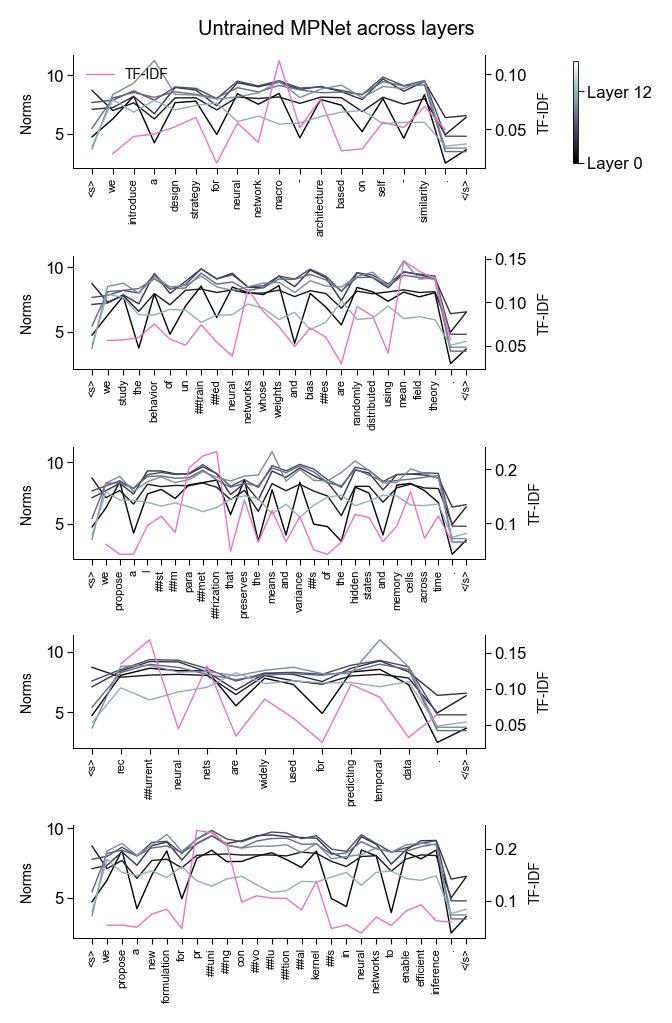

In [471]:
%matplotlib inline
# WITHOUT PAD TOKS

fig, axs = plt.subplots(5, 1, figsize=(3.25, 5), dpi=200, layout="constrained")

# create xticks
inputs = tokenizer(
    dummy_sci_corpus,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)


cmap_offset = 3
colors = plt.cm.bone(np.linspace(0, 1, len(np.arange(7) * 2) + cmap_offset))
# colors = plt.cm.bone(np.linspace(0, 1, len(np.arange(7) * 2)))

fig.suptitle("Untrained MPNet across layers")
for i, ax in enumerate(axs):
    for j, layer_number in enumerate(np.arange(7) * 2):
        untrained = untrained_token_norms_layers_sci[layer_number]
        xticks_labels = np.array(
            tokenizer.convert_ids_to_tokens(inputs["input_ids"][i])
        )
        x = np.arange(untrained.shape[1])[: np.sum(xticks_labels != "<pad>")]
        ax.plot(
            x, untrained[i][: np.sum(xticks_labels != "<pad>")], c=colors[j]
        )  # , label= layer_number)

    ax2 = ax.twinx()
    # print(x[1:-1].shape, tfidf_original_weights_sci[i].shape)
    ax2.plot(
        x[1:-1],
        tfidf_original_weights_sci[i],
        c="tab:pink",
        label="TF-IDF full",
    )
    # ax.plot(x, untrained_token_norms_sci[i][: np.sum(xticks_labels != "<pad>")], c="tab:blue", label= "untrained")

    ax.set_xticks(x)
    ax.set_xticklabels(
        xticks_labels[: np.sum(xticks_labels != "<pad>")],
        fontsize=4,
        rotation="vertical",
    )
    ax.set_ylabel("Norms", fontsize=5)
    ax2.set_ylabel("TF-IDF", fontsize=5)
    if i == 0:
        # ax.plot([],[],c="tab:blue", label= "Untrained")
        ax.plot([], [], c="tab:pink", label="TF-IDF")
        ax.legend(loc="upper left")

        heatmap = ax.scatter([], [], c=[], cmap="bone")
        cbar = plt.colorbar(
            heatmap, ax=ax, shrink=0.9
        )  # , location='left', anchor= (0,0), panchor= (0, 0), pad=-.3, aspect=10)
        # cbar.ax.get_yaxis().set_ticks([0,1])
        cbar.ax.get_yaxis().set_ticks(
            [0, 1 - cmap_offset / (len(np.arange(7) * 2) + cmap_offset)]
        )
        cbar.ax.get_yaxis().set_ticklabels(["Layer 0", "Layer 12"])

    fig.savefig(
        figures_path
        / "tfidf_vs_norm_untrained_MPNet_across_layers_dummy_sci.png"
    )

### SBERT

In [207]:
model_names = [
    # "BERT",
    # "MPNet",
    "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    # "bert-base-uncased",
    # "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [216]:
%%time
# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

sbert_tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
sbert_untrained = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

sbert_untrained.to(device)

Model:  SBERT
Running on device: cuda
sentence-transformers/all-mpnet-base-v2
CPU times: user 1.9 s, sys: 1.25 s, total: 3.16 s
Wall time: 1.17 s


MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [217]:
untrained_sbert_token_embeds_sci = generate_embeddings_all_tokens(
    dummy_sci_corpus, sbert_tokenizer, sbert_untrained, device
)
untrained_sbert_token_norms_sci = np.linalg.norm(
    untrained_sbert_token_embeds_sci, axis=2
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

## Trained model

In [159]:
trained_token_embeds_sci = generate_embeddings_all_tokens(
    dummy_sci_corpus, tokenizer, model_trained, device
)
trained_token_norms_sci = np.linalg.norm(trained_token_embeds_sci, axis=2)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

### Across layers

In [405]:
# preprocess the input
inputs = tokenizer(
    dummy_sci_corpus,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)

# without batches because the dataset is small
out = model_trained(**inputs, output_hidden_states=True)

In [414]:
%%time
trained_token_norms_layers = dict()
for layer_number in np.arange(7) * 2:
    print("Layer ", layer_number)
    trained_token_embeds_layer = (
        out.hidden_states[layer_number].detach().cpu().numpy()
    )
    trained_token_norms_layers[layer_number] = np.linalg.norm(
        trained_token_embeds_layer, axis=2
    )

Layer  0
Layer  2
Layer  4
Layer  6
Layer  8
Layer  10
Layer  12
CPU times: user 3.29 ms, sys: 18.8 ms, total: 22.1 ms
Wall time: 20.8 ms


In [415]:
trained_token_norms_layers[0] == trained_token_norms_layers[2]

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False

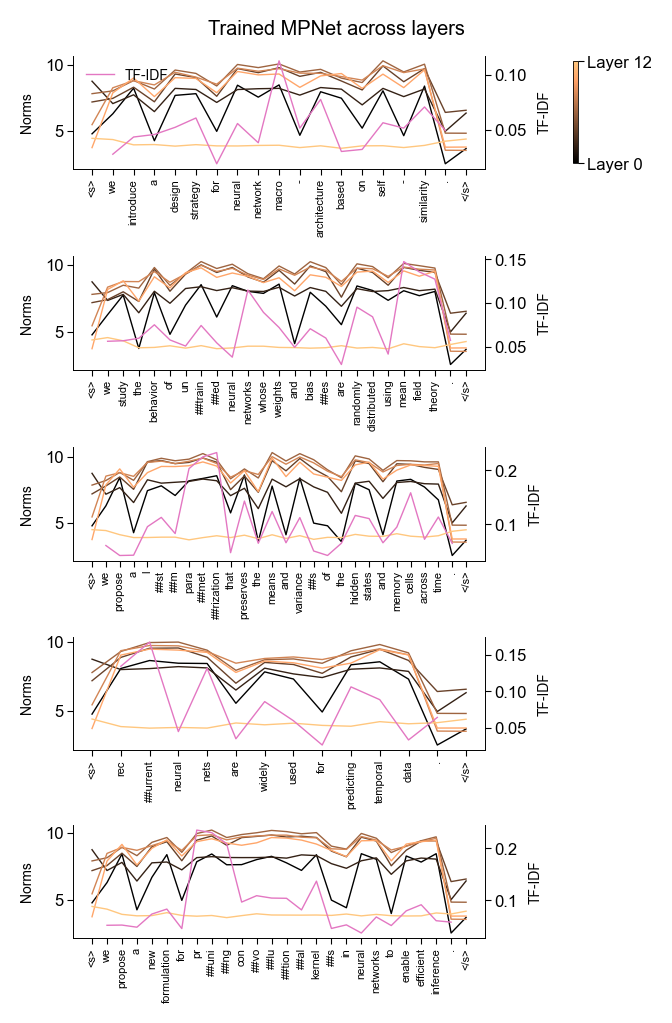

In [477]:
%matplotlib inline
# WITHOUT PAD TOKS

fig, axs = plt.subplots(5, 1, figsize=(3.25, 5), dpi=200, layout="constrained")

# create xticks
inputs = tokenizer(
    dummy_sci_corpus,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)


untrained = untrained_token_norms_sci
colors = plt.cm.copper(np.linspace(0, 1, len(np.arange(7) * 2)))

fig.suptitle("Trained MPNet across layers")
for i, ax in enumerate(axs):
    for j, layer_number in enumerate(np.arange(7) * 2):
        # if j != 0:
        #     continue
        # else:
        trained = trained_token_norms_layers[layer_number]
        xticks_labels = np.array(
            tokenizer.convert_ids_to_tokens(inputs["input_ids"][i])
        )
        x = np.arange(untrained.shape[1])[: np.sum(xticks_labels != "<pad>")]
        ax.plot(
            x, trained[i][: np.sum(xticks_labels != "<pad>")], c=colors[j]
        )  # , label= layer_number)

    ax2 = ax.twinx()
    # ax.plot(
    #     x,
    #     untrained[i][: np.sum(xticks_labels != "<pad>")],
    #     c="tab:blue",
    #     label="untrained",
    # )
    # ax.plot(
    #     x,
    #     2 * trained_token_norms_sci[i][: np.sum(xticks_labels != "<pad>")],
    #     c="tab:orange",
    #     # label="untrained",
    # )

    ax2.plot(
        x[1:-1],
        tfidf_original_weights_sci[i],
        c="tab:pink",
        label="TF-IDF full",
    )

    ax.set_xticks(x)
    ax.set_xticklabels(
        xticks_labels[: np.sum(xticks_labels != "<pad>")],
        fontsize=4,
        rotation="vertical",
    )
    ax.set_ylabel("Norms", fontsize=5)
    ax2.set_ylabel("TF-IDF", fontsize=5)
    if i == 0:
        # ax.plot([],[],c="tab:blue", label= "Untrained")
        ax.plot([], [], c="tab:pink", label="TF-IDF")
        ax.legend(loc="upper left")

        heatmap = ax.scatter([], [], c=[], cmap="copper")
        cbar = plt.colorbar(
            heatmap, ax=ax, shrink=0.9
        )  # , location='left', anchor= (0,0), panchor= (0, 0), pad=-.3, aspect=10)
        cbar.ax.get_yaxis().set_ticks([0, 1])
        cbar.ax.get_yaxis().set_ticklabels(["Layer 0", "Layer 12"])

    fig.savefig(
        figures_path
        / "tfidf_vs_norm_trained_MPNet_across_layers_dummy_sci.png"
    )

## Plot

In [325]:
# get xlabels
inputs = tokenizer(
    dummy_sci_corpus,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)

In [205]:
mpl.rcParams["axes.spines.right"] = True

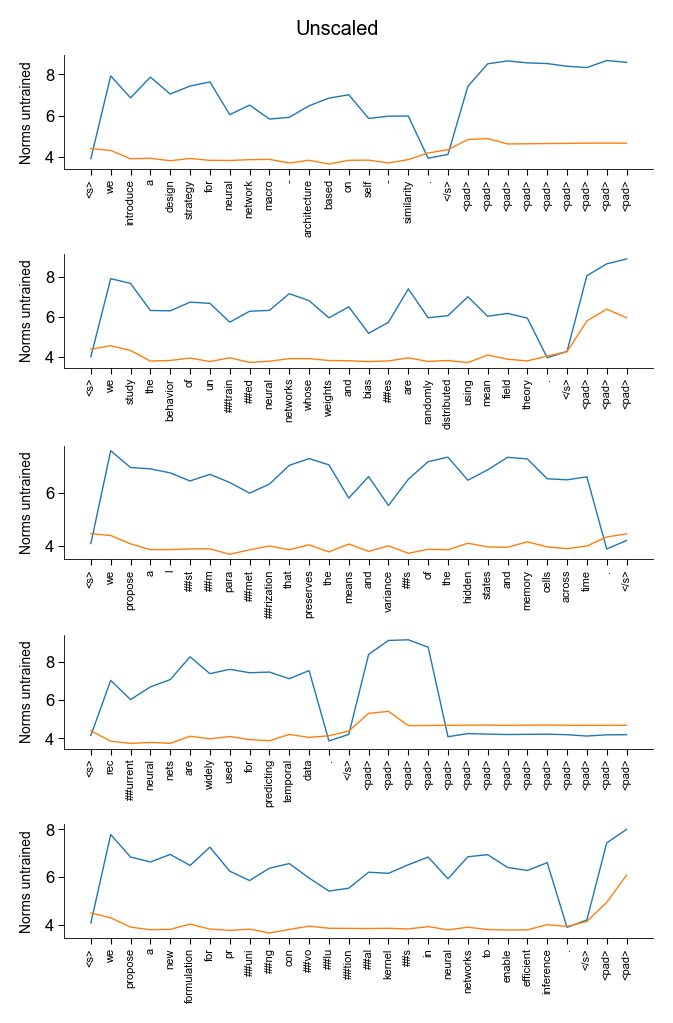

In [392]:
%matplotlib inline

fig, axs = plt.subplots(5, 1, figsize=(3.25, 5), dpi=200, layout="constrained")
# fig, ax = plt.subplots(figsize=(3.25, 1), dpi=200)


fig.suptitle("Unscaled")
for i, ax in enumerate(axs):
    # ax2 = ax.twinx()
    ax.plot(
        np.arange(untrained_token_norms_sci.shape[1]),
        untrained_token_norms_sci[i],
    )
    ax.plot(
        np.arange(trained_token_norms_sci.shape[1]),
        trained_token_norms_sci[i],
        c="tab:orange",
    )
    # ax2.plot(np.arange(trained_token_norms_sci.shape[1]), trained_token_norms_sci[i], c="tab:orange")
    ax.set_xticks(np.arange(trained_token_norms_sci.shape[1]))
    ax.set_xticklabels(
        tokenizer.convert_ids_to_tokens(inputs["input_ids"][i]),
        fontsize=4,
        rotation="vertical",
    )
    ax.set_ylabel("Norms untrained", fontsize=5)
    # ax2.set_ylabel("Norms trained", fontsize=5)

    fig.savefig(
        figures_path
        / "norm_untrained_and_trained_MPNet_unscaled_dummy_sci.png"
    )

In [181]:
xticks_labels = np.array(
    tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
)

xticks_labels[: np.sum(xticks_labels != "<pad>")]

['<s>' 'we' 'introduce' 'a' 'design' 'strategy' 'for' 'neural' 'network'
 'macro' '-' 'architecture' 'based' 'on' 'self' '-' 'similarity' '.'
 '</s>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>'
 '<pad>']


array(['<s>', 'we', 'introduce', 'a', 'design', 'strategy', 'for',
       'neural', 'network', 'macro', '-', 'architecture', 'based', 'on',
       'self', '-', 'similarity', '.', '</s>'], dtype='<U12')

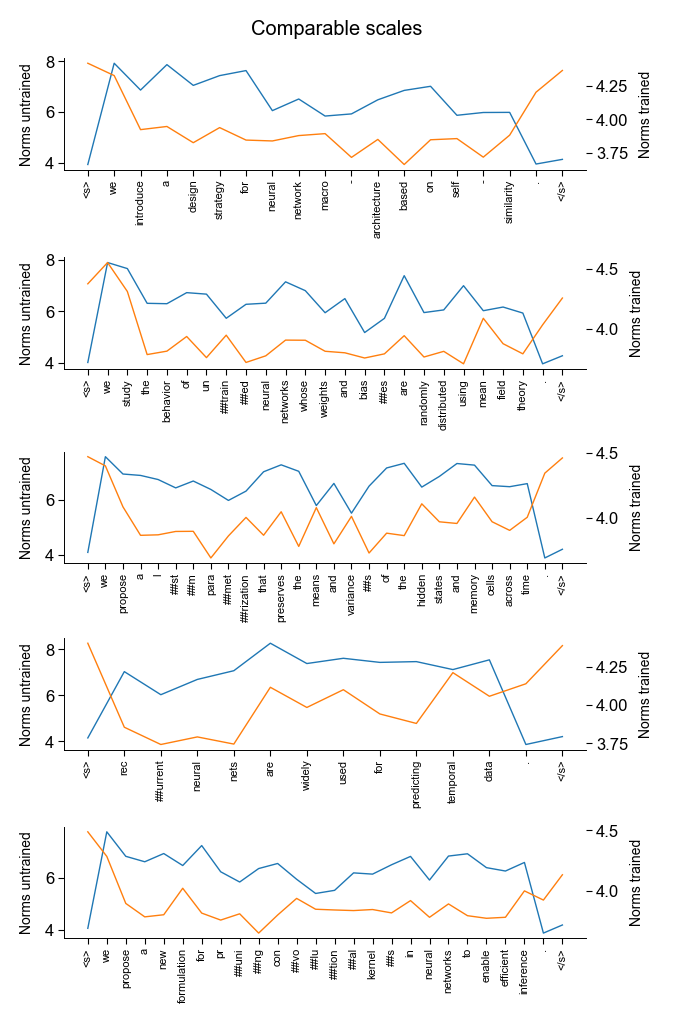

In [397]:
%matplotlib inline
# WITHOUT PAD TOKS

fig, axs = plt.subplots(5, 1, figsize=(3.25, 5), dpi=200, layout="constrained")

fig.suptitle("Comparable scales")
for i, ax in enumerate(axs):
    ax2 = ax.twinx()

    xticks_labels = np.array(
        tokenizer.convert_ids_to_tokens(inputs["input_ids"][i])
    )
    x = np.arange(untrained_token_norms_sci.shape[1])[
        : np.sum(xticks_labels != "<pad>")
    ]
    ax.plot(
        x,
        untrained_token_norms_sci[i][: np.sum(xticks_labels != "<pad>")],
        label="untrained",
    )
    ax2.plot(
        x,
        trained_token_norms_sci[i][: np.sum(xticks_labels != "<pad>")],
        c="tab:orange",
    )
    # ax2.plot(
    #     x,
    #     untrained_sbert_token_norms_sci[i][: np.sum(xticks_labels != "<pad>")],
    #     c="tab:green",
    #     label="SBERT",
    # )

    ax.set_xticks(x)
    ax.set_xticklabels(
        xticks_labels[: np.sum(xticks_labels != "<pad>")],
        fontsize=4,
        rotation="vertical",
    )
    ax.set_ylabel("Norms untrained", fontsize=5)
    ax2.set_ylabel("Norms trained", fontsize=5)

    # if i == 0:
    #     ax.plot([], [], c="tab:orange", label="trained")
    #     ax.plot([], [], c="tab:green", label="SBERT")
    #     ax.legend()

    fig.savefig(
        figures_path / "norm_untrained_and_trained_MPNet_scaled_dummy_sci.png"
    )

## Get TF-IDF weights

### TF-IDF of the dummy corpus only

In [225]:
def mpnet_tokenizer(input_string):
    "The tokenizer should be a function that takes a string and returns an array of its tokens."

    tokenizer = AutoTokenizer.from_pretrained("microsoft/mpnet-base")
    tokenizer_kwargs = dict(
        max_length=512,
        padding=True,
        truncation=True,
        #     return_tensors="pt",
    )
    inputs = tokenizer(input_string, **tokenizer_kwargs)

    return tokenizer.convert_ids_to_tokens(
        inputs["input_ids"], skip_special_tokens=True
    )

In [226]:
%%time
%%memit

# TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, tokenizer=mpnet_tokenizer)
tfidf_dummy_sci = vectorizer.fit_transform(dummy_sci_corpus)
voc_dummy_sci_dict = vectorizer.vocabulary_


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/.pyenv/versions/miniconda3-latest/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


peak memory: 6596.72 MiB, increment: 0.00 MiB
CPU times: user 990 ms, sys: 352 ms, total: 1.34 s
Wall time: 2.17 s


In [ ]:
dense_tfidf_dummy_sci = tfidf_dummy_sci.toarray()

In [252]:
voc_dummy_sci_dict = vectorizer.vocabulary_
voc_dummy_sci_dict

{'we': 74,
 'introduce': 38,
 'a': 17,
 'design': 28,
 'strategy': 62,
 'for': 33,
 'neural': 48,
 'network': 46,
 'macro': 41,
 '-': 15,
 'architecture': 20,
 'based': 22,
 'on': 51,
 'self': 59,
 'similarity': 60,
 '.': 16,
 'study': 63,
 'the': 66,
 'behavior': 23,
 'of': 50,
 'un': 70,
 '##train': 11,
 '##ed': 1,
 'networks': 47,
 'whose': 76,
 'weights': 75,
 'and': 19,
 'bias': 24,
 '##es': 2,
 'are': 21,
 'randomly': 57,
 'distributed': 29,
 'using': 72,
 'mean': 42,
 'field': 32,
 'theory': 67,
 'propose': 56,
 'l': 40,
 '##st': 9,
 '##m': 4,
 'para': 52,
 '##met': 5,
 '##rization': 7,
 'that': 65,
 'preserves': 55,
 'means': 43,
 'variance': 73,
 '##s': 8,
 'hidden': 35,
 'states': 61,
 'memory': 44,
 'cells': 25,
 'across': 18,
 'time': 68,
 'rec': 58,
 '##urrent': 13,
 'nets': 45,
 'widely': 77,
 'used': 71,
 'predicting': 54,
 'temporal': 64,
 'data': 27,
 'new': 49,
 'formulation': 34,
 'pr': 53,
 '##uni': 12,
 '##ng': 6,
 'con': 26,
 '##vo': 14,
 '##lu': 3,
 '##tion': 10,

In [259]:
# GET TF-IDF WEIGHTS

# making sure the input is the correct one
tokenizer = AutoTokenizer.from_pretrained("microsoft/mpnet-base")
inputs = tokenizer(
    dummy_sci_corpus,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)


# code
tfidf_weights_sci = []
for i in range(len(dummy_sci_corpus)):
    tokens = np.array(
        tokenizer.convert_ids_to_tokens(
            inputs["input_ids"][i], skip_special_tokens=True
        )
    )
    indices = np.vectorize(voc_dummy_sci_dict.get)(tokens)
    tfidf_weights_sci.append(dense_tfidf_dummy_sci[i, indices])

In [262]:
tfidf_weights_sci

[array([0.1473147 , 0.26148253, 0.1751179 , 0.26148253, 0.26148253,
        0.1751179 , 0.1473147 , 0.26148253, 0.26148253, 0.44272841,
        0.26148253, 0.26148253, 0.26148253, 0.26148253, 0.44272841,
        0.26148253, 0.12459783]),
 array([0.1288546 , 0.22871599, 0.18452662, 0.22871599, 0.18452662,
        0.22871599, 0.22871599, 0.22871599, 0.1288546 , 0.18452662,
        0.22871599, 0.22871599, 0.18452662, 0.22871599, 0.22871599,
        0.18452662, 0.22871599, 0.22871599, 0.22871599, 0.22871599,
        0.22871599, 0.22871599, 0.10898439]),
 array([0.1183051 , 0.16941918, 0.14063323, 0.20999071, 0.20999071,
        0.20999071, 0.20999071, 0.20999071, 0.20999071, 0.20999071,
        0.20999071, 0.28685161, 0.20999071, 0.28685161, 0.20999071,
        0.16941918, 0.16941918, 0.28685161, 0.20999071, 0.20999071,
        0.28685161, 0.20999071, 0.20999071, 0.20999071, 0.20999071,
        0.1000617 ]),
 array([0.3220134 , 0.3220134 , 0.18141673, 0.3220134 , 0.25979838,
        0.3220

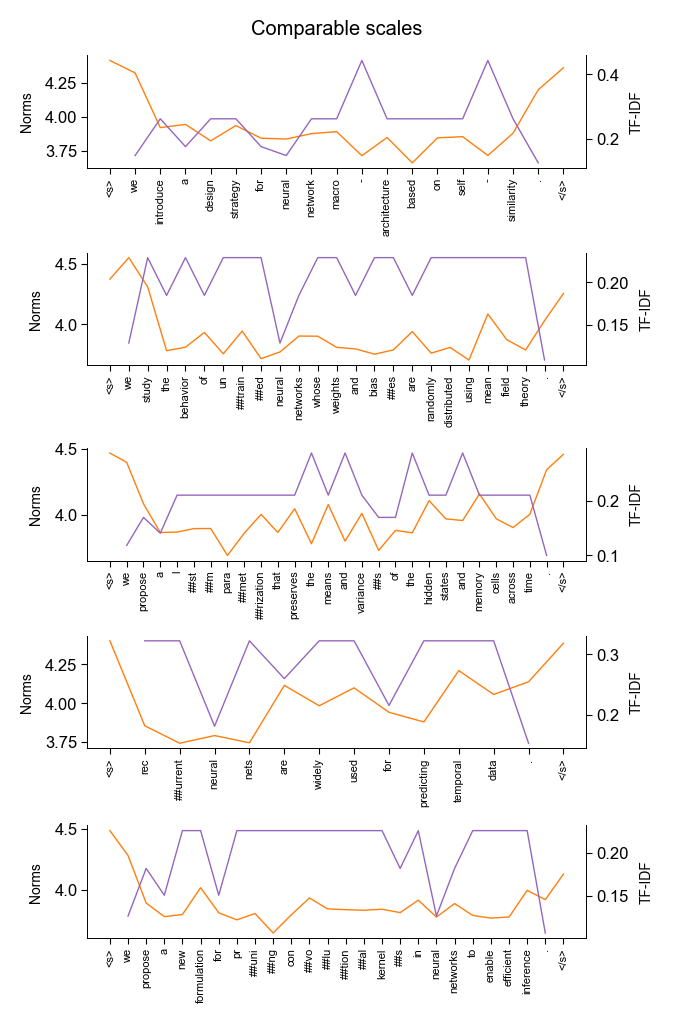

In [298]:
%matplotlib inline
# WITHOUT PAD TOKS

fig, axs = plt.subplots(5,1, figsize=(3.25, 5), dpi=200, layout="constrained")


fig.suptitle("Comparable scales")
for i, ax in enumerate(axs):
    ax2 = ax.twinx()
    
    xticks_labels = np.array(
        tokenizer.convert_ids_to_tokens(inputs["input_ids"][i])
    )
    x = np.arange(untrained_token_norms_sci.shape[1])[: np.sum(xticks_labels != "<pad>")]
    # ax.plot(x, untrained_token_norms_sci[i][: np.sum(xticks_labels != "<pad>")],label = "untrained")
    ax.plot(x, trained_token_norms_sci[i][: np.sum(xticks_labels != "<pad>")], c="tab:orange")
    ax2.plot(x[1:-1], tfidf_weights_sci[i], c="tab:purple", label="TF-IDF")

    ax.set_xticks(x)
    ax.set_xticklabels(xticks_labels[: np.sum(xticks_labels != "<pad>")], fontsize=4, rotation="vertical")
    ax.set_ylabel("Norms", fontsize=5)
    ax2.set_ylabel("TF-IDF", fontsize=5)

    # if i == 0:
    #     ax.plot([],[],c="tab:orange", label= "trained")
    #     ax.legend()



### TF-IDF of the whole ICLR corpus

In [274]:
%%time
%%memit

# TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, tokenizer=mpnet_tokenizer)
tfidf_features = vectorizer.fit_transform(iclr2024.abstract.to_list())
voc_dict = vectorizer.vocabulary_

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/.pyenv/versions/miniconda3-latest/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [275]:
# save results
sp.sparse.save_npz(
    variables_path / "updated_dataset" / "tfidf_features_mpnet_tokenizer",
    tfidf_features,
)
np.save(
    variables_path / "updated_dataset" / "vocabulary_tfidf_mpnet_tokenizer",
    voc_dict,
)

In [276]:
print(tfidf_features.shape)

(24347, 16345)


In [277]:
%%memit
dense_tfidf_first_5 = tfidf_features[:5].toarray()

peak memory: 12544.98 MiB, increment: 0.64 MiB


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [278]:
print(dense_tfidf_first_5.shape)

(5, 16345)


In [398]:
mpl.rcParams["axes.spines.right"] = True

In [390]:
# GET TF-IDF WEIGHTS

# making sure the input is the correct one
tokenizer = AutoTokenizer.from_pretrained("microsoft/mpnet-base")
inputs = tokenizer(
    dummy_sci_corpus,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)


# code
tfidf_original_weights_sci = []
for i in range(len(dummy_sci_corpus)):
    tokens = np.array(
        tokenizer.convert_ids_to_tokens(
            inputs["input_ids"][i], skip_special_tokens=True
        )
    )
    indices = np.vectorize(voc_dict.get)(tokens)
    tfidf_original_weights_sci.append(dense_tfidf_first_5[i, indices])

In [429]:
tfidf_original_weights_sci[0].shape

(17,)

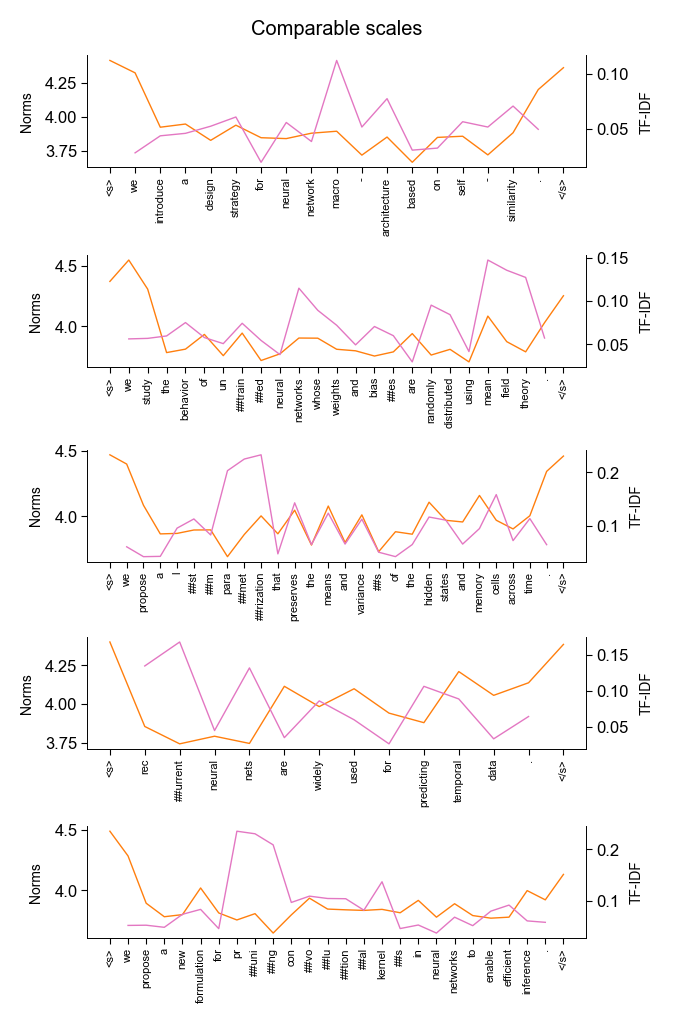

In [284]:
%matplotlib inline
# WITHOUT PAD TOKS

fig, axs = plt.subplots(5,1, figsize=(3.25, 5), dpi=200, layout="constrained")


fig.suptitle("Comparable scales")
for i, ax in enumerate(axs):
    ax2 = ax.twinx()
    
    xticks_labels = np.array(
        tokenizer.convert_ids_to_tokens(inputs["input_ids"][i])
    )
    x = np.arange(untrained_token_norms_sci.shape[1])[: np.sum(xticks_labels != "<pad>")]
    # ax.plot(x, untrained_token_norms_sci[i][: np.sum(xticks_labels != "<pad>")],label = "untrained")
    ax.plot(x, trained_token_norms_sci[i][: np.sum(xticks_labels != "<pad>")], c="tab:orange")
    # ax2.plot(x[1:-1], tfidf_weights_sci[i], c="tab:purple", label="TF-IDF")
    ax2.plot(x[1:-1], tfidf_original_weights_sci[i], c="tab:pink", label="TF-IDF full")

    ax.set_xticks(x)
    ax.set_xticklabels(xticks_labels[: np.sum(xticks_labels != "<pad>")], fontsize=4, rotation="vertical")
    ax.set_ylabel("Norms", fontsize=5)
    ax2.set_ylabel("TF-IDF", fontsize=5)

    # if i == 0:
    #     ax.plot([],[],c="tab:orange", label= "trained")
    #     ax.legend()



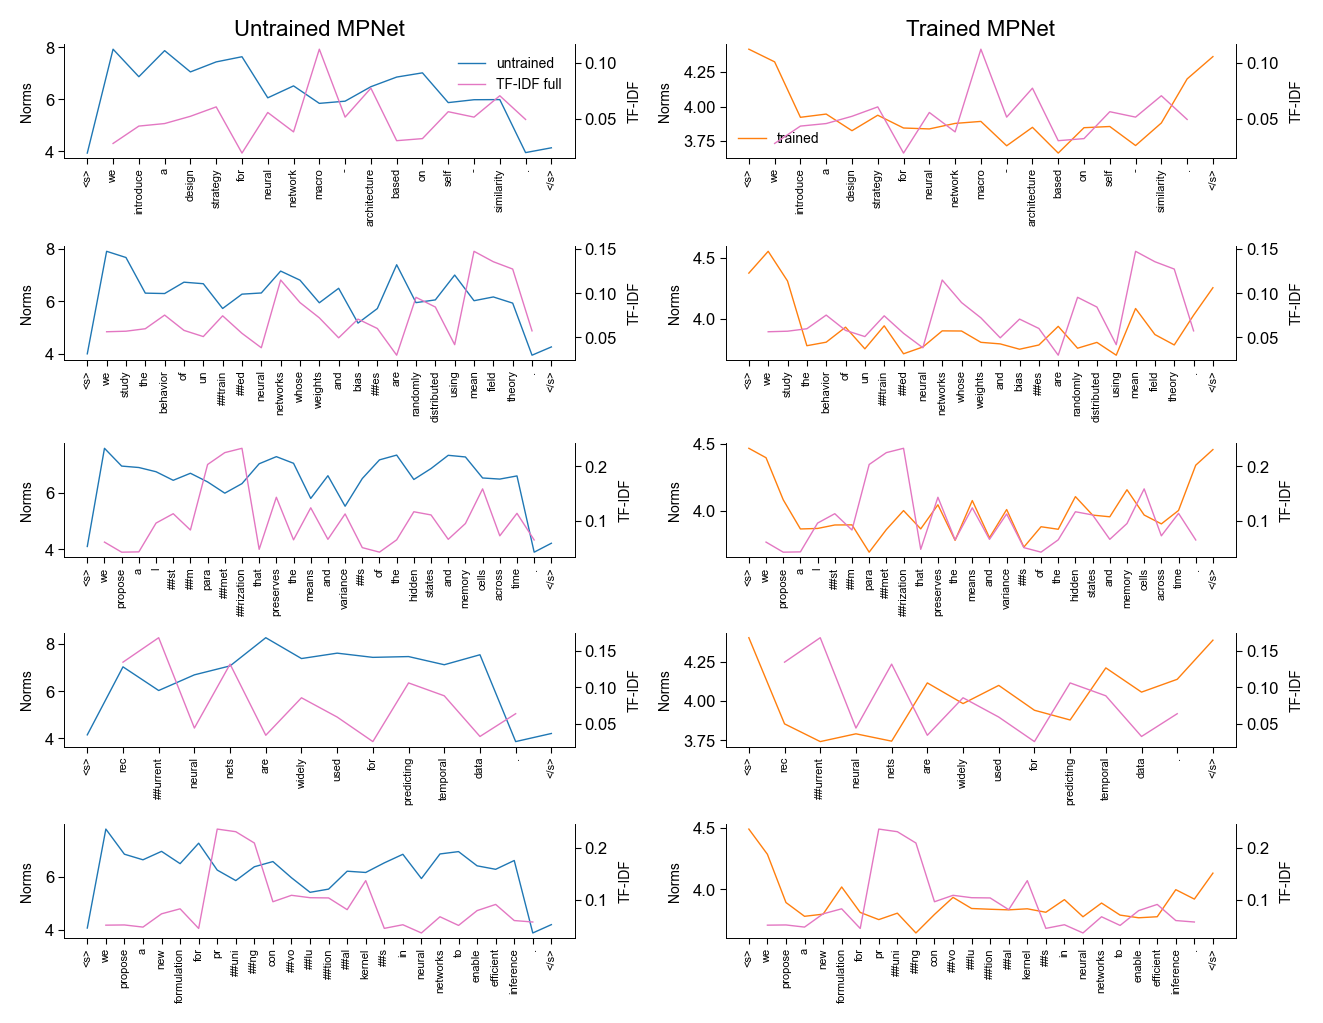

In [399]:
%matplotlib inline
# TWO COLUMNS PLOT

fig, axs = plt.subplots(5, 2, figsize=(6.5, 5), dpi=200, layout="constrained")

for i, ax in enumerate(axs):
    ax20 = ax[0].twinx()
    ax21 = ax[1].twinx()

    xticks_labels = np.array(
        tokenizer.convert_ids_to_tokens(inputs["input_ids"][i])
    )
    x = np.arange(untrained_token_norms_sci.shape[1])[
        : np.sum(xticks_labels != "<pad>")
    ]
    ax[0].plot(
        x,
        untrained_token_norms_sci[i][: np.sum(xticks_labels != "<pad>")],
        label="untrained",
    )
    ax[1].plot(
        x,
        trained_token_norms_sci[i][: np.sum(xticks_labels != "<pad>")],
        c="tab:orange",
        label="trained",
    )
    # ax[1].plot(
    #     x,
    #     untrained_sbert_token_norms_sci[i][: np.sum(xticks_labels != "<pad>")],
    #     c="tab:green",
    #     label="SBERT",
    # )

    # ax2.plot(x[1:-1], tfidf_weights_sci[i], c="tab:purple", label="TF-IDF")
    ax20.plot(
        x[1:-1],
        tfidf_original_weights_sci[i],
        c="tab:pink",
        label="TF-IDF full",
    )
    ax21.plot(
        x[1:-1],
        tfidf_original_weights_sci[i],
        c="tab:pink",
        label="TF-IDF full",
    )

    ax[0].set_xticks(x)
    ax[0].set_xticklabels(
        xticks_labels[: np.sum(xticks_labels != "<pad>")],
        fontsize=4,
        rotation="vertical",
    )
    ax[0].set_ylabel("Norms", fontsize=5)
    ax20.set_ylabel("TF-IDF", fontsize=5)

    ax[1].set_xticks(x)
    ax[1].set_xticklabels(
        xticks_labels[: np.sum(xticks_labels != "<pad>")],
        fontsize=4,
        rotation="vertical",
    )
    ax[1].set_ylabel("Norms", fontsize=5)
    ax21.set_ylabel("TF-IDF", fontsize=5)

    if i == 0:
        ax[0].plot(
            [],
            [],
            c="tab:pink",
            label="TF-IDF full",
        )
        ax[0].legend()
        ax[1].legend()
        # ax20.legend()
        # ax21.legend()
        ax[0].set_title("Untrained MPNet")
        ax[1].set_title("Trained MPNet")

    fig.savefig(
        figures_path
        / "tfidf_vs_norm_untrained_and_trained_MPNet_dummy_sci.png"
    )

# ICLR corpus

## Untrained MPNet

In [69]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [70]:
%%time
# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model_untrained = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

model_untrained.to(device)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
CPU times: user 1.78 s, sys: 1.37 s, total: 3.15 s
Wall time: 1.36 s


MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [71]:
%%time
untrained_token_embeds_iclr = generate_embeddings_all_tokens(
    iclr2024.abstract.to_list(),
    tokenizer,
    model_untrained,
    device,
    show_progress=True,
)

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

CPU times: user 2min 25s, sys: 3min 43s, total: 6min 9s
Wall time: 4min 13s


In [72]:
%%time
untrained_token_norms_iclr = np.linalg.norm(
    untrained_token_embeds_iclr, axis=2
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/token_norms_experiment"
)
np.save(
    variables_path / saving_path / "untrained_token_norms_iclr",
    untrained_token_norms_iclr,
)

CPU times: user 8.71 s, sys: 9.01 s, total: 17.7 s
Wall time: 17.7 s


In [306]:
print(untrained_token_embeds_iclr.shape)
print(untrained_token_norms_iclr.shape)

(24347, 512, 768)
(24347, 512)


### Across layers

In [24]:
%%time
for layer_number in np.arange(7) * 2:
    print("Layer: ", layer_number)
    # get embeddings
    untrained_token_embeds_layers_iclr = (
        generate_embeddings_all_tokens_across_layers(
            iclr2024.abstract.to_list(),
            tokenizer,
            model_untrained,
            device,
            layers=[layer_number],
            show_progress=True,
        )
    )
    # calculate norms
    untrained_token_norms_layers_iclr = np.linalg.norm(
        untrained_token_embeds_layers_iclr[layer_number], axis=2
    )
    # saving
    model_name = "mpnet"
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset/token_norms_experiment"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(
        variables_path
        / saving_path
        / f"untrained_token_norms_layer_{layer_number}_iclr",
        untrained_token_norms_layers_iclr,
    )

Layer:  0


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Layer:  2


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Layer:  4


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Layer:  6


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Layer:  8


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Layer:  10


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Layer:  12


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

CPU times: user 19min 38s, sys: 24min 38s, total: 44min 17s
Wall time: 29min 44s


## Trained MPNet

In [25]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [26]:
%%time
# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model_untrained = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("Training loader length: ", len(training_loader))

model_trained, losses = train_loop_without_eval(
    model_untrained,
    training_loader,
    device,
    optimized_rep="av",
    n_epochs=1,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Training loader length:  368


  0%|          | 0/368 [00:00<?, ?it/s]

CPU times: user 5min 59s, sys: 4min 24s, total: 10min 23s
Wall time: 5min 16s


In [73]:
%%time
trained_token_embeds_iclr = generate_embeddings_all_tokens(
    iclr2024.abstract.to_list(),
    tokenizer,
    model_trained,
    device,
    show_progress=True,
)

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

CPU times: user 2min 24s, sys: 3min 41s, total: 6min 6s
Wall time: 4min 12s


In [74]:
%%time
trained_token_norms_iclr = np.linalg.norm(trained_token_embeds_iclr, axis=2)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/token_norms_experiment"
)
np.save(
    variables_path / saving_path / "trained_token_norms_iclr",
    trained_token_norms_iclr,
)

CPU times: user 12.5 s, sys: 12 s, total: 24.5 s
Wall time: 24.5 s


### Across layers

In [79]:
%%time
for layer_number in np.arange(7) * 2:
    print("Layer: ", layer_number)
    # get embeddings
    trained_token_embeds_layers_iclr = (
        generate_embeddings_all_tokens_across_layers(
            iclr2024.abstract.to_list(),
            tokenizer,
            model_trained,
            device,
            layers=[layer_number],
            show_progress=True,
        )
    )
    # calculate norms
    trained_token_norms_layers_iclr = np.linalg.norm(
        trained_token_embeds_layers_iclr[layer_number], axis=2
    )
    # saving
    model_name = "mpnet"
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset/token_norms_experiment"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(
        variables_path
        / saving_path
        / f"trained_token_norms_layer_{layer_number}_iclr",
        trained_token_norms_layers_iclr,
    )

Layer:  0


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Layer:  2


  0%|          | 0/96 [00:00<?, ?it/s]

OSError: [Errno 12] Cannot allocate memory

## TF-IDF weights

In [44]:
# load
tfidf_features = sp.sparse.load_npz(
    variables_path / "updated_dataset" / "tfidf_features_mpnet_tokenizer.npz",
)
voc_dict = np.load(
    variables_path
    / "updated_dataset"
    / "vocabulary_tfidf_mpnet_tokenizer.npy",
    allow_pickle=True,
).item()

In [45]:
voc_dict  # .item()

{'we': 15995,
 'introduce': 9786,
 'a': 4055,
 'design': 7019,
 'strategy': 14535,
 'for': 8470,
 'neural': 11270,
 'network': 11266,
 'macro': 10531,
 '-': 3562,
 'architecture': 4682,
 'based': 5056,
 'on': 11520,
 'self': 13755,
 'similarity': 14014,
 '.': 3563,
 'repeated': 13133,
 'application': 4635,
 'of': 11482,
 'simple': 14017,
 'expansion': 8010,
 'rule': 13494,
 'generates': 8718,
 'deep': 6860,
 'networks': 11268,
 'whose': 16077,
 'structural': 14578,
 'layout': 10201,
 '##s': 2752,
 'are': 4686,
 'precisely': 12301,
 'truncated': 15424,
 'fra': 8539,
 '##cta': 593,
 '##ls': 1826,
 'these': 15076,
 'contain': 6385,
 'interacting': 9725,
 'sub': 14612,
 '##path': 2366,
 'different': 7125,
 'lengths': 10266,
 ',': 3561,
 'but': 5502,
 'do': 7310,
 'not': 11355,
 'include': 9492,
 'any': 4596,
 'pass': 11833,
 'through': 15125,
 'or': 11577,
 'residual': 13205,
 'connections': 6310,
 ';': 4043,
 'every': 7912,
 'internal': 9749,
 'signal': 13991,
 'is': 9860,
 'transformed':

In [46]:
%%memit
dense_tfidf = tfidf_features.toarray()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 187013.48 MiB, increment: 0.00 MiB


In [47]:
%%time
# GET TF-IDF WEIGHTS

# making sure the input is the correct one
tokenizer = AutoTokenizer.from_pretrained("microsoft/mpnet-base")
inputs = tokenizer(
    iclr2024.abstract.to_list(),
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)


# get them
tfidf_original_weights_iclr = []
for i in range(len(iclr2024.abstract.to_list())):
    tokens = np.array(
        tokenizer.convert_ids_to_tokens(
            inputs["input_ids"][i], skip_special_tokens=True
        )
    )
    indices = np.vectorize(voc_dict.get)(tokens)
    tfidf_original_weights_iclr.append(dense_tfidf[i, indices])

CPU times: user 4min 49s, sys: 1min 3s, total: 5min 53s
Wall time: 4min 34s


In [48]:
# save
len(tfidf_original_weights_iclr)

24347

In [50]:
# save
model_name = "mpnet"
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/token_norms_experiment"
)

f = open(
    variables_path / saving_path / "tfidf_original_weights_iclr.pkl", "wb"
)
pickle.dump(tfidf_original_weights_iclr, f)
f.close()

## Correlation analysis
Things to take into account:
- exclude the pad tokens from the MPNet's output
- individual correlation for each document, and then average across all documents? This compare untrained vs. trained

In [318]:
print(inputs["attention_mask"].shape)
inputs["attention_mask"][0]

torch.Size([24347, 512])


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [323]:
print(
    len(tfidf_original_weights_iclr[0])
    == np.sum(inputs["attention_mask"][0].detach().cpu().numpy()) - 2
)

True


In [ ]:
# Two vectors are
for i in range(len(tfidf_original_weights_iclr)): #24347
    tfidf_original_weights_iclr[i]
    == np.sum(inputs["attention_mask"][0].detach().cpu().numpy()) - 2
)

True


### Plot

In [378]:
# test bool
i = 2855
a = trained_token_norms_iclr[i]
b = inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)

# print(a)
print(a.shape)
print(type(a))
# print(b)
print(b.shape)
print(type(b))

print(a[b].shape)
a[b]

(512,)
<class 'numpy.ndarray'>
(512,)
<class 'numpy.ndarray'>
(216,)


array([4.6634564, 4.566086 , 4.1363297, 4.059316 , 4.0758924, 3.916474 ,
       3.9771478, 3.8102846, 3.8651187, 3.9940674, 3.896902 , 3.8408155,
       3.945585 , 4.1850886, 4.001016 , 3.823303 , 3.9026053, 3.8345504,
       3.9288454, 3.7825089, 4.222973 , 4.0400295, 4.145305 , 4.231133 ,
       4.2247934, 4.141707 , 3.8142252, 3.8873258, 4.258106 , 4.118116 ,
       3.739085 , 3.8605988, 4.0316286, 3.80481  , 4.047982 , 3.6553211,
       3.9082956, 3.8718028, 4.00169  , 3.839654 , 3.8636525, 4.090888 ,
       3.9849553, 4.3103166, 3.7105267, 3.992409 , 3.9679708, 4.090531 ,
       3.9952555, 4.171709 , 3.797471 , 4.0774274, 3.7455041, 4.096928 ,
       4.1058526, 3.714056 , 3.798226 , 4.0103526, 4.1179147, 3.977459 ,
       4.3661175, 4.0610375, 3.7352498, 4.1796412, 3.7635207, 3.9105508,
       3.8757699, 3.8799648, 3.9084113, 3.9566634, 4.36568  , 3.8485026,
       4.401986 , 3.8467712, 4.0129538, 3.9602413, 4.0524335, 3.7143767,
       3.678224 , 3.9876583, 4.081065 , 3.8691993, 

In [379]:
tfidf_original_weights_iclr[i].shape

(212,)

In [383]:
print(np.array(tokenizer.convert_ids_to_tokens(inputs["input_ids"][i])))

['<s>' 'we' 'study' 'discrete' 'time' 'dynamic' '##al' 'systems'
 'governed' 'by' 'the' 'state' 'equation' '$' 'h' '_' '{' 't' '+' '1' '}'
 '=' '[UNK]' '(' 'ah' '_' 't' '+' 'bu' '_' 't' ')' '$' '.' 'here' 'a' ','
 'b' 'are' 'weight' 'matrices' ',' '[UNK]' 'is' 'an' 'activation'
 'function' ',' 'and' '$' 'u' '_' 't' '$' 'is' 'the' 'input' 'data' '.'
 'this' 'relation' 'is' 'the' 'backbone' 'of' 'rec' '##urrent' 'neural'
 'networks' '(' 'e' '.' 'g' '.' 'l' '##st' '##ms' ')' 'which' 'have'
 'broad' 'applications' 'in' 'sequential' 'learning' 'tasks' '.' 'we'
 'utilize' 'st' '##och' '##astic' 'gradient' 'descent' 'to' 'learn' 'the'
 'weight' 'matrices' 'from' 'a' 'finite' 'input' '/' 'state' 'trajectory'
 '$' '(' 'u' '_' 't' ',' 'h' '_' 't' ')' '_' '{' 't' '=' '0' '}' '^' 'n'
 '$' '.' 'we' 'prove' 'that' 'sg' '##d' 'estimate' 'linear' '##ly'
 'converge' '##s' 'to' 'the' 'ground' 'truth' 'weights' 'while' 'using'
 'near' '-' 'optimal' 'sample' 'size' '.' 'our' 'results' 'apply' 'to'
 'incre

In [385]:
print(iclr2024.abstract.iloc[2855])

We study discrete time dynamical systems governed by the state equation $h_{t+1}=ϕ(Ah_t+Bu_t)$. Here A,B are weight matrices, ϕ is an activation function, and $u_t$ is the input data. This relation is the backbone of recurrent neural networks (e.g. LSTMs) which have broad applications in sequential learning tasks. We utilize stochastic gradient descent to learn the weight matrices from a finite input/state trajectory $(u_t,h_t)_{t=0}^N$. We prove that SGD estimate linearly converges to the ground truth weights while using near-optimal sample size. Our results apply to increasing activations whose derivatives are bounded away from zero. The analysis is based on i) an SGD convergence result with nonlinear activations and ii) careful statistical characterization of the state vector. Numerical experiments verify the fast convergence of SGD on ReLU and leaky ReLU in consistence with our theory.


In [ ]:
# making sure the input is the correct one
tokenizer = AutoTokenizer.from_pretrained("microsoft/mpnet-base")
inputs = tokenizer(
    iclr2024.abstract.to_list(),
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)

In [496]:
mpl.rcParams["axes.spines.right"] = False

CPU times: user 7min 59s, sys: 3.93 s, total: 8min 3s
Wall time: 8min 4s


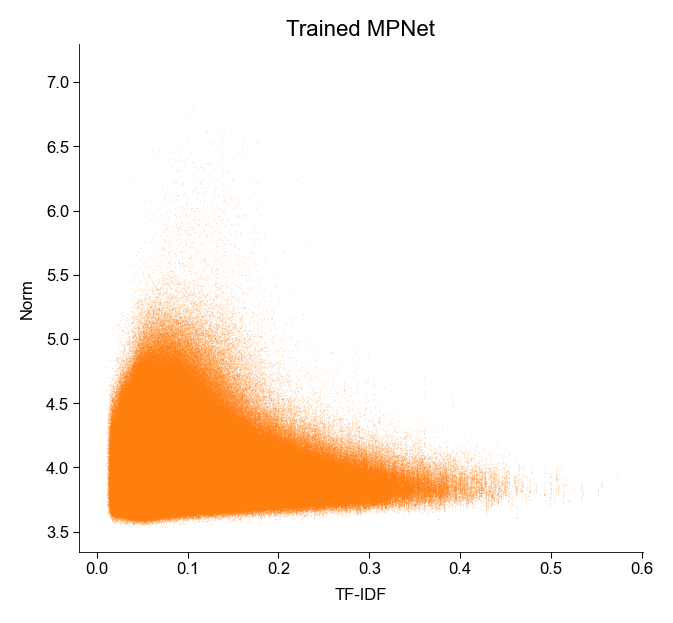

In [386]:
%%time

%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 3), dpi=200, layout="constrained")
n_not_maching = 0
for i in range(len(tfidf_original_weights_iclr)):  # 24347
    # assert (
    #     tfidf_original_weights_iclr[i].shape
    #     == trained_token_norms_iclr[i][
    #         inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)
    #     ][1:-1].shape
    # ), f"{i}"

    if (
        tfidf_original_weights_iclr[i].shape
        != trained_token_norms_iclr[i][
            inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)
        ][1:-1].shape
    ):
        n_not_maching += 1
        continue

    ax.scatter(
        tfidf_original_weights_iclr[i],
        trained_token_norms_iclr[i][
            inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)
        ][1:-1],
        c="tab:orange",
        s=0.5,
        alpha=0.3,
        marker=".",
        linewidths=0,
        ec="None",
        rasterized=True,
    )
ax.set_xlabel("TF-IDF")
ax.set_ylabel("Norm")
ax.set_title("Trained MPNet")

fig.savefig(figures_path / "tfidf_vs_norm_trained_mpnet.png")

In [387]:
print(n_not_maching)

41


41
CPU times: user 7min 38s, sys: 2.7 s, total: 7min 41s
Wall time: 7min 41s


Text(0.5, 1.0, 'Untrained MPNet')

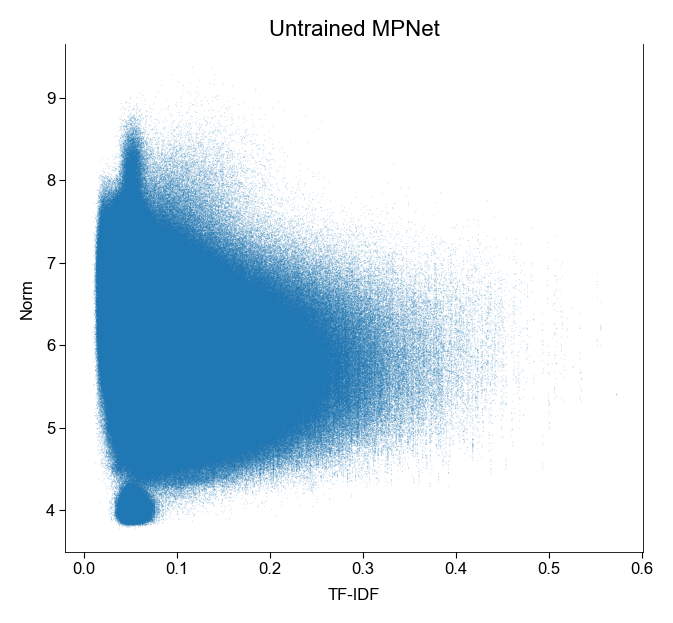

In [495]:
%%time

%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 3), dpi=200, layout="constrained")
n_not_maching = 0
for i in range(len(tfidf_original_weights_iclr)):  # 24347
    if (
        tfidf_original_weights_iclr[i].shape
        != untrained_token_norms_iclr[i][
            inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)
        ][1:-1].shape
    ):
        n_not_maching += 1
        continue

    ax.scatter(
        tfidf_original_weights_iclr[i],
        untrained_token_norms_iclr[i][
            inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)
        ][1:-1],
        c="tab:blue",
        s=0.5,
        alpha=0.3,
        marker=".",
        linewidths=0,
        ec="None",
        rasterized=True,
    )

print(n_not_maching)
ax.set_xlabel("TF-IDF")
ax.set_ylabel("Norm")
ax.set_title("Untrained MPNet")

fig.savefig(figures_path / "tfidf_vs_norm_untrained_mpnet.png")

### Calculate the correlation value
Average correlation in between token_norm-tfidf_weight for every abstract and have a look at the distribution of this before vs. after training.

#### ICLR data

In [ ]:
# load 
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/token_norms_experiment"
)
untrained_token_norms_iclr = np.load(
    variables_path / saving_path / "untrained_token_norms_iclr.npy",
)
trained_token_norms_iclr = np.load(
    variables_path / saving_path / "trained_token_norms_iclr.npy",
)

In [75]:
# making sure the input is the correct one
tokenizer = AutoTokenizer.from_pretrained("microsoft/mpnet-base")
inputs = tokenizer(
    iclr2024.abstract.to_list(),
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)

In [76]:
%%time

untrained_correlations = np.zeros(len(tfidf_original_weights_iclr))
abstracts_to_exclude_untrained = np.zeros(
    len(tfidf_original_weights_iclr), dtype=bool
)
n_not_maching = 0
for i in range(len(tfidf_original_weights_iclr)):  # 24347
    if (
        tfidf_original_weights_iclr[i].shape
        != untrained_token_norms_iclr[i][
            inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)
        ][1:-1].shape
    ):
        n_not_maching += 1
        abstracts_to_exclude_untrained[i] = True

        continue

    untrained_correlations[i] = sp.stats.pearsonr(
        tfidf_original_weights_iclr[i],
        untrained_token_norms_iclr[i][
            inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)
        ][1:-1],
    )[0]
print(n_not_maching)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/token_norms_experiment"
)
np.save(
    variables_path / saving_path / "untrained_correlations_iclr",
    untrained_correlations,
)

41
CPU times: user 18.6 s, sys: 225 ms, total: 18.8 s
Wall time: 18.9 s


In [77]:
%%time

trained_correlations = np.zeros(len(tfidf_original_weights_iclr))
abstracts_to_exclude_trained = np.zeros(
    len(tfidf_original_weights_iclr), dtype=bool
)
n_not_maching = 0
for i in range(len(tfidf_original_weights_iclr)):  # 24347
    if (
        tfidf_original_weights_iclr[i].shape
        != trained_token_norms_iclr[i][
            inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)
        ][1:-1].shape
    ):
        n_not_maching += 1
        abstracts_to_exclude_trained[i] = True

        continue

    trained_correlations[i] = sp.stats.pearsonr(
        tfidf_original_weights_iclr[i],
        trained_token_norms_iclr[i][
            inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)
        ][1:-1],
    )[0]
print(n_not_maching)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/token_norms_experiment"
)
np.save(
    variables_path / saving_path / "trained_correlations_iclr",
    trained_correlations,
)

41
CPU times: user 18.7 s, sys: 342 ms, total: 19 s
Wall time: 19.1 s


In [518]:
~abstracts_to_exclude_trained

array([ True,  True,  True, ...,  True,  True,  True])

CPU times: user 20.1 ms, sys: 7.4 ms, total: 27.5 ms
Wall time: 26.3 ms


(-0.8, 0.4)

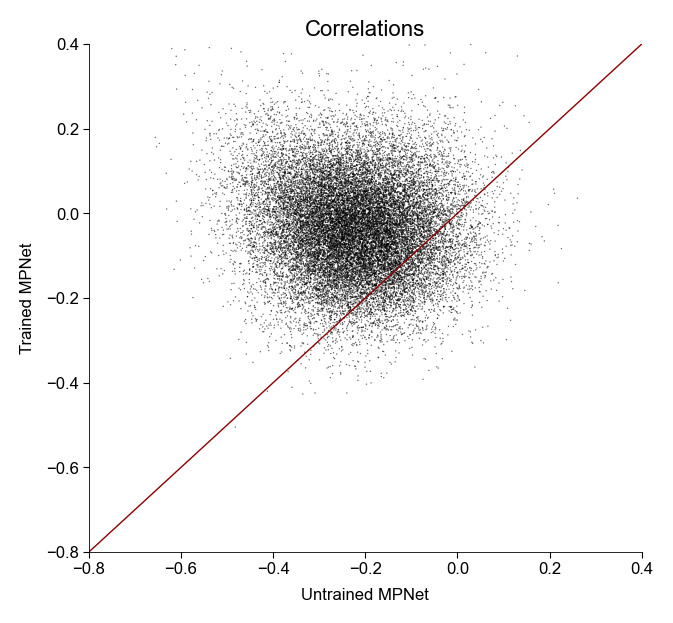

In [78]:
%%time

%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 3), dpi=200, layout="constrained")


ax.scatter(
    untrained_correlations[~abstracts_to_exclude_trained],
    trained_correlations[~abstracts_to_exclude_trained],
    c="k",
    s=1,
    alpha=0.6,
    marker=".",
    linewidths=0,
    ec="None",
    rasterized=True,
)
ax.plot([-0.8, 0.4], [-0.8, 0.4], c="darkred")
ax.set_xlabel("Untrained MPNet")
ax.set_ylabel("Trained MPNet")
ax.set_title("Correlations")
ax.set_xlim(-0.8, 0.4)
ax.set_ylim(-0.8, 0.4)
# ax.axis("equal")

# fig.savefig(figures_path / "correlations_untrained_vs_trained_mpnet.png")

In [531]:
print(np.amin(untrained_correlations))
print(np.amax(untrained_correlations))
print(np.amin(trained_correlations))
print(np.amax(trained_correlations))

-0.6552703009637801
0.26052631211973715
-0.5044657518116327
0.4797139191425215


In [535]:
bin_edges_corr = np.linspace(-1, 1, 100)

In [537]:
%%time

counts_corr_untrained, bins_untrained = np.histogram(
    untrained_correlations, bins=bin_edges_corr
)
counts_corr_trained, bins_trained = np.histogram(
    trained_correlations, bins=bin_edges_corr
)

CPU times: user 1.14 ms, sys: 54 µs, total: 1.2 ms
Wall time: 811 µs


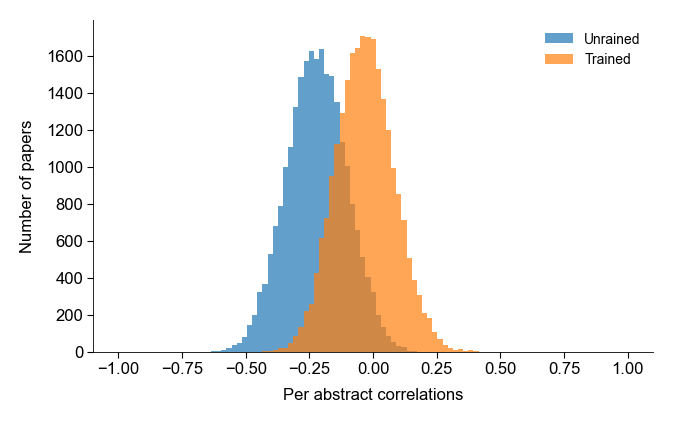

In [572]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200, layout="constrained")

ax.hist(
    bins_untrained[:-1],
    bins_untrained,
    weights=counts_corr_untrained,
    color="tab:blue",
    alpha=0.7,
    label="Unrained",
)
ax.hist(
    bins_trained[:-1],
    bins_trained,
    weights=counts_corr_trained,
    color="tab:orange",
    alpha=0.7,
    label="Trained",
)
ax.set_ylabel("Number of papers")
ax.set_xlabel("Per abstract correlations")
ax.legend()

fig.savefig(
    figures_path / "correlations_distribution_untrained_and_trained_mpnet.png"
)

### Across layers

#### Untrained

In [28]:
# making sure the input is the correct one
tokenizer = AutoTokenizer.from_pretrained("microsoft/mpnet-base")
inputs = tokenizer(
    iclr2024.abstract.to_list(),
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)

In [51]:
%%time

untrained_correlations_layers_iclr = dict()
abstracts_to_exclude_untrained = np.zeros(
    len(tfidf_original_weights_iclr), dtype=bool
)
for j, layer_number in enumerate(np.arange(7) * 2):
    print("Layer : ", layer_number)

    # load norms of that layer
    # saving
    model_name = "mpnet"
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset/token_norms_experiment"
    )
    untrained_token_norms_iclr = np.load(
        variables_path
        / saving_path
        / f"untrained_token_norms_layer_{layer_number}_iclr.npy"
    )

    # initialize empty array
    untrained_correlations = np.zeros(len(tfidf_original_weights_iclr))
    n_not_maching = 0

    # compute correlations for every abstract
    for i in range(len(tfidf_original_weights_iclr)):  # 24347
        # exclude cases where abstract has weird symbols that make the number of tokens not to match with number of tfidf tokens (despite using the same tokenizer)
        if (
            tfidf_original_weights_iclr[i].shape
            != untrained_token_norms_iclr[i][
                inputs["attention_mask"][i]
                .detach()
                .cpu()
                .numpy()
                .astype(np.bool_)
            ][1:-1].shape
        ):
            n_not_maching += 1
            abstracts_to_exclude_untrained[i] = True

            continue
        # calculate correlation
        untrained_correlations[i] = sp.stats.pearsonr(
            tfidf_original_weights_iclr[i],
            untrained_token_norms_iclr[i][
                inputs["attention_mask"][i]
                .detach()
                .cpu()
                .numpy()
                .astype(np.bool_)
            ][1:-1],
        )[0]

    untrained_correlations_layers_iclr[layer_number] = untrained_correlations
    print(n_not_maching)

# save
## corr
f = open(
    variables_path / saving_path / "untrained_correlations_layers_iclr.pkl",
    "wb",
)
pickle.dump(untrained_correlations_layers_iclr, f)
f.close()

## mask -- should be the same for untrained and trained cases, and across layers
np.save(
    variables_path / saving_path / "abstracts_to_exclude_untrained",
    abstracts_to_exclude_untrained,
)

Layer :  0
41
Layer :  2
41
Layer :  4
41
Layer :  6
41
Layer :  8
41
Layer :  10
41
Layer :  12
41
CPU times: user 2min 9s, sys: 2.5 s, total: 2min 11s
Wall time: 2min 12s


#### Trained -- RERUN

In [ ]:
# # making sure the input is the correct one
# tokenizer = AutoTokenizer.from_pretrained("microsoft/mpnet-base")
# inputs = tokenizer(
#     iclr2024.abstract.to_list(),
#     padding=True,
#     truncation=True,
#     return_tensors="pt",
#     max_length=512,
# ).to(device)

In [80]:
%%time

trained_correlations_layers_iclr = dict()
abstracts_to_exclude_untrained = np.zeros(
    len(tfidf_original_weights_iclr), dtype=bool
)
for j, layer_number in enumerate(np.arange(7) * 2):
    print("Layer : ", layer_number)

    # load norms of that layer
    # saving
    model_name = "mpnet"
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset/token_norms_experiment"
    )
    trained_token_norms_iclr = np.load(
        variables_path
        / saving_path
        / f"trained_token_norms_layer_{layer_number}_iclr.npy"
    )

    # initialize empty array
    trained_correlations = np.zeros(len(tfidf_original_weights_iclr))
    n_not_maching = 0

    # compute correlations for every abstract
    for i in range(len(tfidf_original_weights_iclr)):  # 24347
        # exclude cases where abstract has weird symbols that make the number of tokens not to match with number of tfidf tokens (despite using the same tokenizer)
        if (
            tfidf_original_weights_iclr[i].shape
            != trained_token_norms_iclr[i][
                inputs["attention_mask"][i]
                .detach()
                .cpu()
                .numpy()
                .astype(np.bool_)
            ][1:-1].shape
        ):
            n_not_maching += 1
            abstracts_to_exclude_untrained[i] = True

            continue
        # calculate correlation
        trained_correlations[i] = sp.stats.pearsonr(
            tfidf_original_weights_iclr[i],
            trained_token_norms_iclr[i][
                inputs["attention_mask"][i]
                .detach()
                .cpu()
                .numpy()
                .astype(np.bool_)
            ][1:-1],
        )[0]

    trained_correlations_layers_iclr[layer_number] = trained_correlations
    print(n_not_maching)

# save
## corr
f = open(
    variables_path / saving_path / "trained_correlations_layers_iclr.pkl",
    "wb",
)
pickle.dump(trained_correlations_layers_iclr, f)
f.close()

## mask -- should be the same for untrained and trained cases, and across layers -- THAT IS WHY I DON'T SAVE IT AGAIN
# np.save(
#     variables_path / saving_path / "abstracts_to_exclude_untrained",
#     abstracts_to_exclude_untrained,
# )

Layer :  0
41
Layer :  2


#### Plot

CPU times: user 2.46 s, sys: 4.4 s, total: 6.86 s
Wall time: 1.2 s


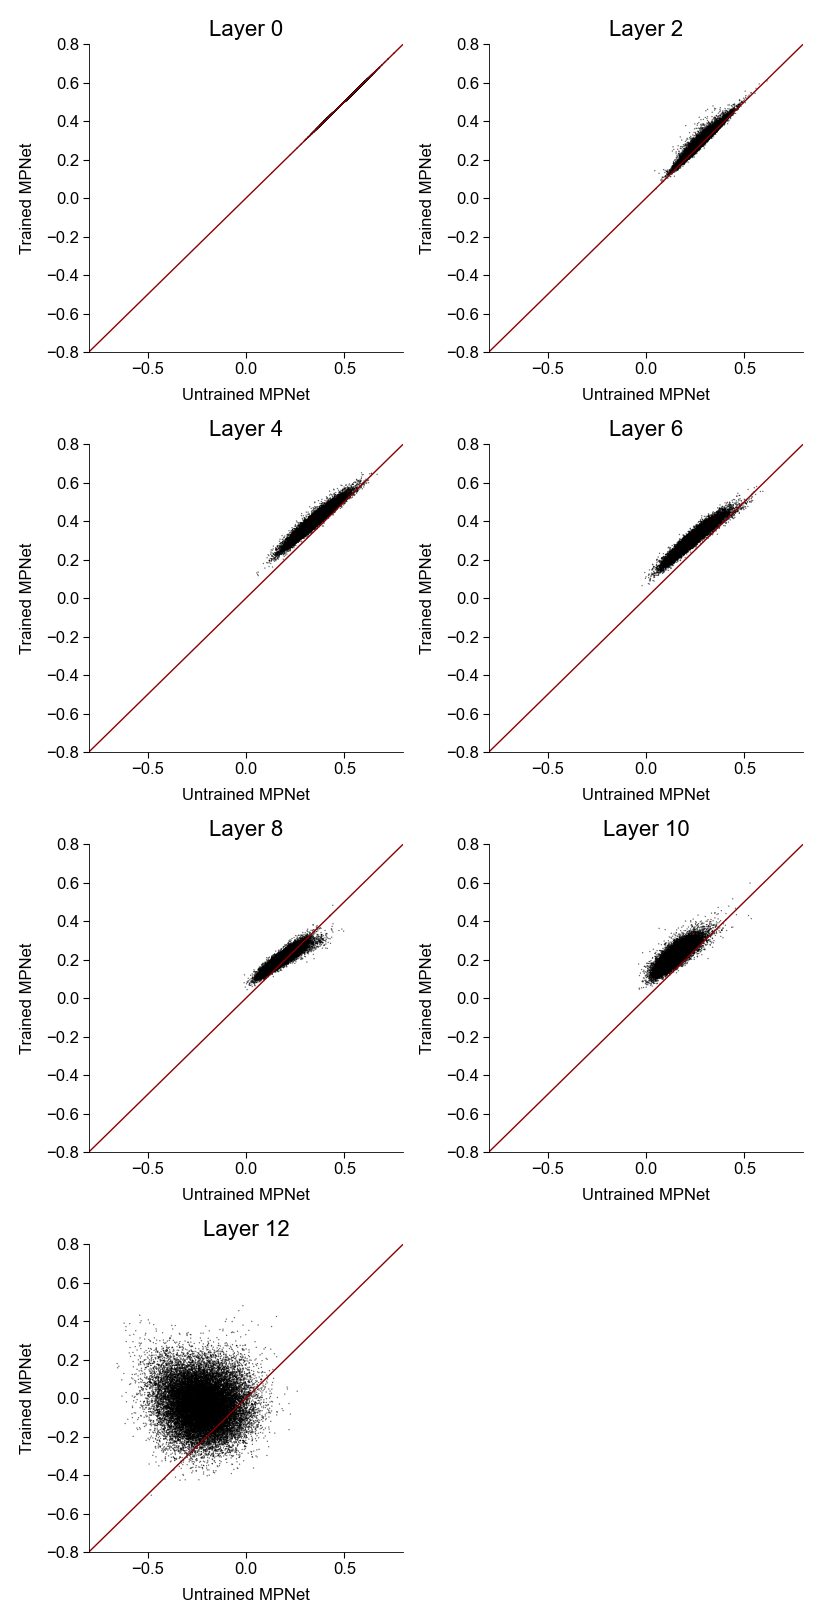

In [81]:
%%time

%matplotlib inline
fig, axs = plt.subplots(4, 2, figsize=(4, 8), dpi=200, layout="constrained")
layers = np.arange(7) * 2

# load
model_name = "mpnet"
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/token_norms_experiment"
)

## corr
pickle_in = open(
    variables_path / saving_path / "untrained_correlations_layers_iclr.pkl",
    "rb",
)
untrained_correlations_layers_iclr = pickle.load(pickle_in)

pickle_in = open(
    variables_path / saving_path / "trained_correlations_layers_iclr.pkl", "rb"
)
trained_correlations_layers_iclr = pickle.load(pickle_in)


## mask
abstracts_to_exclude = np.load(
    variables_path / saving_path / "abstracts_to_exclude_untrained.npy",
)

for i, ax in enumerate(axs.flatten()):
    if ax == axs.flatten()[-1]:
        ax.axis("off")
    else:
        layer_number = layers[i]
        # load

        untrained_correlations = untrained_correlations_layers_iclr[
            layer_number
        ]
        trained_correlations = trained_correlations_layers_iclr[layer_number]

        # plot
        ax.scatter(
            untrained_correlations[~abstracts_to_exclude],
            trained_correlations[~abstracts_to_exclude],
            c="k",
            s=1,
            alpha=0.6,
            marker=".",
            linewidths=0,
            ec="None",
            rasterized=True,
        )
        ax.plot([-0.8, 0.8], [-0.8, 0.8], c="darkred")
        ax.set_xlabel("Untrained MPNet")
        ax.set_ylabel("Trained MPNet")
        ax.set_title(f"Layer {layer_number}")
        ax.set_xlim(-0.8, 0.8)
        ax.set_ylim(-0.8, 0.8)
# ax.axis("equal")

fig.savefig(
    figures_path / "correlations_across_layers_untrained_vs_trained_mpnet.png"
)

CPU times: user 2.98 s, sys: 298 ms, total: 3.28 s
Wall time: 3.02 s


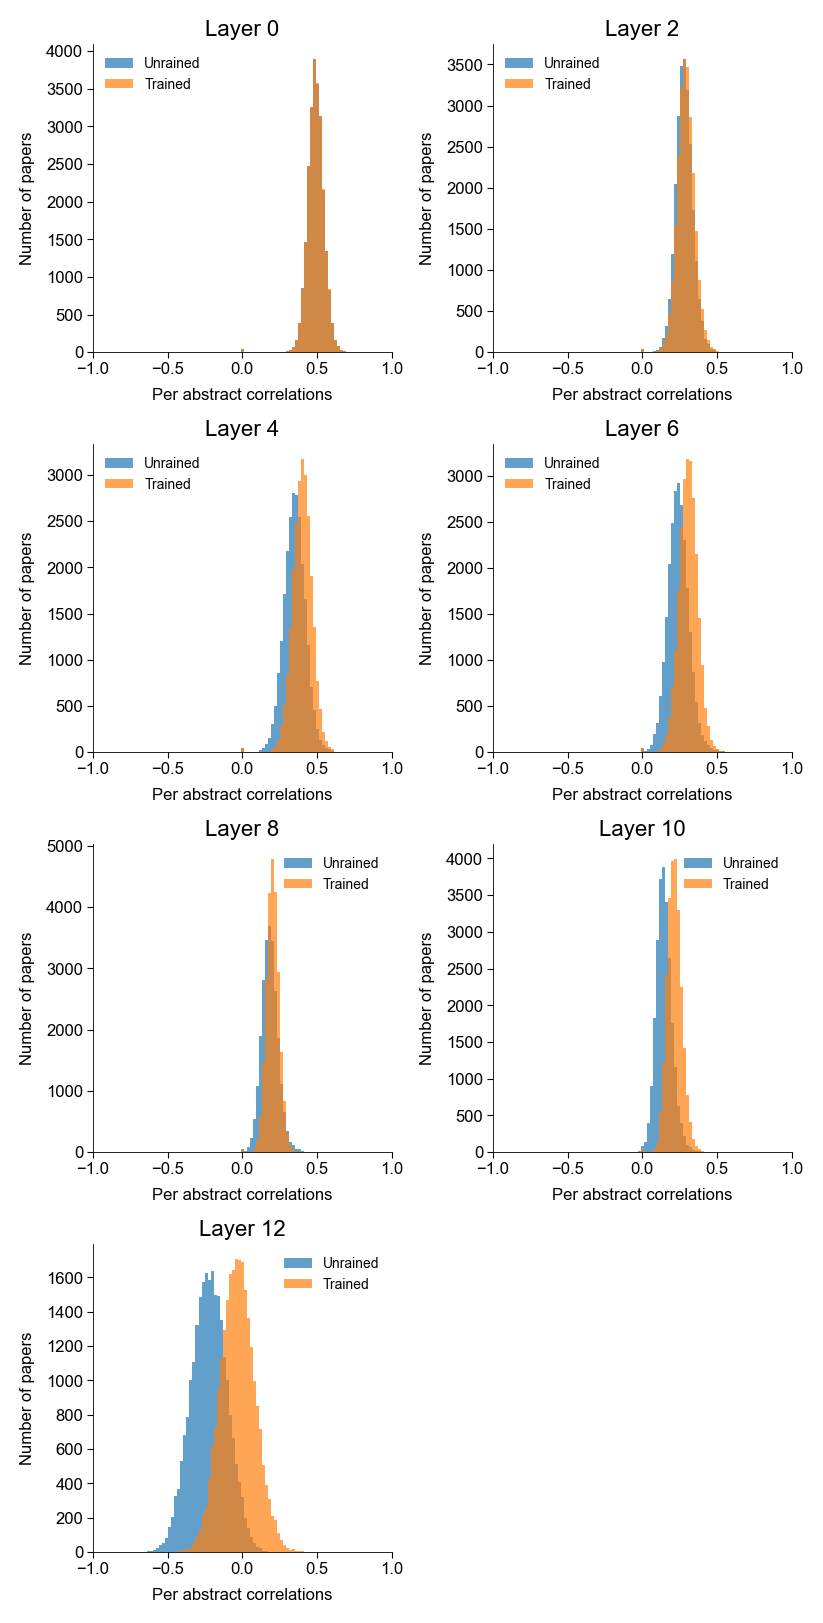

In [83]:
%%time

%matplotlib inline
fig, axs = plt.subplots(4, 2, figsize=(4, 8), dpi=200, layout="constrained")
layers = np.arange(7) * 2

# load
model_name = "mpnet"
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/token_norms_experiment"
)

## corr
pickle_in = open(
    variables_path / saving_path / "untrained_correlations_layers_iclr.pkl",
    "rb",
)
untrained_correlations_layers_iclr = pickle.load(pickle_in)

pickle_in = open(
    variables_path / saving_path / "trained_correlations_layers_iclr.pkl", "rb"
)
trained_correlations_layers_iclr = pickle.load(pickle_in)


## mask
abstracts_to_exclude = np.load(
    variables_path / saving_path / "abstracts_to_exclude_untrained.npy",
)
bin_edges_corr = np.linspace(-1, 1, 100)

for i, ax in enumerate(axs.flatten()):
    if ax == axs.flatten()[-1]:
        ax.axis("off")
    else:
        layer_number = layers[i]
        # get layers
        untrained_correlations = untrained_correlations_layers_iclr[
            layer_number
        ]
        trained_correlations = trained_correlations_layers_iclr[layer_number]

        # compute histogram
        counts_corr_untrained, bins_untrained = np.histogram(
            untrained_correlations, bins=bin_edges_corr
        )
        counts_corr_trained, bins_trained = np.histogram(
            trained_correlations, bins=bin_edges_corr
        )
        # plot
        ax.hist(
            bins_untrained[:-1],
            bins_untrained,
            weights=counts_corr_untrained,
            color="tab:blue",
            alpha=0.7,
            label="Unrained",
        )
        ax.hist(
            bins_trained[:-1],
            bins_trained,
            weights=counts_corr_trained,
            color="tab:orange",
            alpha=0.7,
            label="Trained",
        )
        ax.set_ylabel("Number of papers")
        ax.set_xlabel("Per abstract correlations")
        ax.legend()
        ax.set_title(f"Layer {layer_number}")
        ax.set_xlim(-1, 1)

# ax.axis("equal")

fig.savefig(
    figures_path
    / "correlations_distribution_across_layers_untrained_vs_trained_mpnet.png"
)